<a href="https://colab.research.google.com/github/metamath1/ml-simple-works/blob/master/mnistattn/mnist_attn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2
from tqdm import tqdm

# 어텐션 쉽게 이해하기Attention is easy to understand.
---
2021.05.15 조준우(metamath@gmail.com)



이번 글에서는 최근 딥러닝의 강력한 트랜드인 어텐션에 대해서 알아보겠습니다. 이 블로그의 글이 늘 그렇듯이 보통 문서와는 조금 다른 방식으로 어텐션을 소개할까 합니다. 이렇게 다른 방식으로 어텐션을 이야기하게 된 이유는 기존 방식대로 어텐션을 설명하면 문서를 이해하기 위해 독자가 알아야할 선행 지식이 너무 많아지기 때문입니다. 보통 어텐션을 seq2seq를 사용하여 설명하는데 seq2seq를 알기 위해서는 인코더, 디코더, 임베딩같은 용어가 난무하는 언어모델을 알아야합니다. 그리고 언어모델을 제대로 이해하기 위해서는 RNN을 알아야 합니다. 이렇게 부가적으로 알아야할 사항이 너무 많아지는데 본질적으로 어텐션은 이런 부가적인 요소들과 별 상관없다는 것이 기존 설명을 회의적으로 생각하게된 계기가 되었습니다.

그래서 이 글에서는 친숙한 mnist 데이터 셋을 사용합니다. mnist 데이터 셋을 이용하여 어텐션을 설명하는 글도 인터넷에서 볼 수 있지만 대부분 "Show, Atend and Tell"[1]에서 이용한 방식으로 설명합니다. [1]에서 다루는 태스크는 이미지 캡셔닝으로 CNN과 RNN이 총동원되는 작업입니다. 업친데 덥친격으로 RNN뿐 아니라 CNN까지 알아야해서 seq2seq보다 더 복잡합니다.

이런 이유로 CNN조차 사용하지 않는 간단한 mnist 분류 문제에 어텐션을 적용하여 어텐션의 본질만 직관적으로 설명하도록 하겠습니다. 이 글을 위해 알아야 할 선행 지식은 기본적인 신경망 모델인 MLP(Multi Layer Perceptron)뿐입니다.

---

[1] Show, Attend and Tell: Neural Image Caption Generation with Visual Attention, https://arxiv.org/abs/1502.03044






## 개요

mnist를 MLP를 이용하여 분류할 때 가장 기본적으로 적용하는 방법은 가로 세로 28x28인 이미지를 요소가 784개인 벡터로 펼친 다음 이를 신경망에 입력하여 출력 열개를 뽑아내는 방법입니다. 여기서는 어텐션을 적용하기 위해 mnist 이미지를 작은 패치 열여섯개로 잘라서 각각을 신경망에 입력하도록 하겠습니다. 아래 그림 1은 이렇게 잘린 숫자 이미지를 나타냅니다.   

![picture](https://drive.google.com/uc?id=1hvDbkk15eAT4bQ-uFnwo3SAqmxF9cFU4)
그림 1: Mnist 분할

이렇게 잘린 작은 이미지 조각 열여섯개를 각각 `Linear()`층에 입력하고 그 결과를 연결시켜 긴 벡터로 만들고 이를 다시 `Linear()`층으로 입력시켜 클래스에 속할 확률 열개를 뽑아내도록 할 것입니다. 아래는 이런 기본적인 MLP 모델의 모식도 입니다. 

```
Patch1--->Linear1(49,16)------┌---┐
Patch2--->Linear2(49,16)------| c |
Patch3--->Linear3(49,16)------| o |
Patch4--->Linear4(49,16)------| n |                   
...                     ------| c |-----Linear(16*16,10)----softmax() 
...                     ------| a |
...                     ------| t |
Patch16--->Linear16(49,16)----└---┘
```

mnist 이미지 분류를 위해 보통 사용하는 구조를 쓰지 않고 이렇게 이미지를 패치로 잘라서 입력하는 이유는 분할된 각 패치에 어텐션을 주기 위해서입니다. 위 이미지를 예로 들어 이야기해보면 왼쪽 이미지에서 8이라는 숫자를 예측하기 위해 집중해야할 패치는 왼쪽 아래부분 여섯개라는 것을 알 수 있습니다. 그렇기 때문에 이 여섯개 패치가 `Linear()`층을 통과하여 생성된 결과에 큰 어텐션 가중치attention weight를 곱해주면 분류 성능이 더 올라갈것이라 예상해볼 수 있습니다. 이를 확인하기 위해 위 모식도에 있는 기본 모델을 만들고 여기에 어텐션 가중치가 추가된 모델을 만들어 두 모델의 결과를 비교하도록 하겠습니다.

이상 설명한 실험은 이미지를 자르기만하면 기존 MLP를 그대로 이용할 수 있습니다. 

## 이미지 분할

이미지를 분할해서 개별 패치를 각각 `Linear`층에 입력하기보다 그냥 patch_size x patch_size 크기를 가지는 conv 필터를 만들고 스트라이드를 patch_size x patch_size으로 주면 동일한 작업을 수행할 수 있습니다.(conv 연산은 가중치를 공유하므로 완전히 동일하지는 않습니다.) 하지만 이 글은 RNN, CNN같은 이야기를 하지 않기로 했으므로 직접 이미지를 패치로 잘라서 MLP에 입력하기로 하겠습니다.





### 이미지 분할 함수

행렬을 `패치개수x패치개수`개의 부분 행렬로 만드는 함수를 준비합니다. 이 함수는 코드 주석에 표시된 `stackoverflow`에서 인용한 것이며 미니배치에 대해서 동작하도록 약간 수정하였습니다. 

In [ ]:
# https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays
def blockshaped(arr, nrows, ncols):
    """
    arr: (N, H, W)

    Return an array of shape (n, h//nrows, w//ncols, nrows, ncols) where
    n * h//nrows * w//ncols * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    n, h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    # 원본
    # return arr.reshape(h//nrows, nrows, -1, ncols).swapaxes(1,2).reshape(-1, nrows, ncols)
    return ( arr.reshape(n, h//nrows, nrows, -1, ncols).transpose(0, 1, 3, 2, 4)
                .reshape(-1, h//nrows, w//ncols, nrows, ncols) )



###  이미지 분할 함수 테스트

만들어진 함수가 제대로 동작하는지 (28,28)인 행렬 세개가 있는 (3, 28, 28)인 텐서를 열여섯개 패치로 자르는 테스트를 해보겠습니다.  (3, 28, 28)을 (7,7)인 패치로 잘라서 전체 텐서가 (3, 4, 4, 7, 7)로 만들어져야 합니다. 여기서 3은 샘플의 인덱스, (4, 4)는 패치의 인덱스, (7, 7)은 패치 하나에서 픽셀의 인덱스가 됩니다.

In [ ]:
images = np.arange(784*3).reshape(3,28,28)
images = blockshaped(images, 7, 7)
images.shape

(3, 4, 4, 7, 7)

텐서의 모양은 제대로 출력이 되었습니다. 이제 첫번째 이미지에서 1행에 있는 패치 네개를 출력해서 숫자들이 행별로 연속되는지 확인해보면

In [ ]:
images[0,0,0], images[0,0,1], images[0,0,2], images[0,0,3]

(array([[  0,   1,   2,   3,   4,   5,   6],
        [ 28,  29,  30,  31,  32,  33,  34],
        [ 56,  57,  58,  59,  60,  61,  62],
        [ 84,  85,  86,  87,  88,  89,  90],
        [112, 113, 114, 115, 116, 117, 118],
        [140, 141, 142, 143, 144, 145, 146],
        [168, 169, 170, 171, 172, 173, 174]]),
 array([[  7,   8,   9,  10,  11,  12,  13],
        [ 35,  36,  37,  38,  39,  40,  41],
        [ 63,  64,  65,  66,  67,  68,  69],
        [ 91,  92,  93,  94,  95,  96,  97],
        [119, 120, 121, 122, 123, 124, 125],
        [147, 148, 149, 150, 151, 152, 153],
        [175, 176, 177, 178, 179, 180, 181]]),
 array([[ 14,  15,  16,  17,  18,  19,  20],
        [ 42,  43,  44,  45,  46,  47,  48],
        [ 70,  71,  72,  73,  74,  75,  76],
        [ 98,  99, 100, 101, 102, 103, 104],
        [126, 127, 128, 129, 130, 131, 132],
        [154, 155, 156, 157, 158, 159, 160],
        [182, 183, 184, 185, 186, 187, 188]]),
 array([[ 21,  22,  23,  24,  25,  26,  27],
    

출력된 패치 네개의 각 행별 숫자가 연속되는 것을 확인할 수 있습니다. 즉 위 출력된 7x7패치 네개는 가로 방향으로 연결되어 있는 이미지입니다.

 이미지를 자르는 함수가 준비되었으니 실제 데이터에 적용하고 이미지를 약간 수정하는 방법도 알아봅시다.

## 이미지 분할과 증강augmentation 테스트

이 글을 적고 있는 구글 코랩에서 mnist 데이터 셋을 제공하므로 바로 불러 쓸 수 있습니다. 아래처럼 csv 파일로 저장된 mnist 데이터를 읽어옵니다. 이 csv파일에는 한 행에 이미지 하나를 저장하고 있으며 첫 열은 타겟값으로 0에서 9까지 숫자이며 두번째 열부터는 이미지 밝기값으로 0에서 255까지 범위를 가집니다.

In [ ]:
# csv파일을 pandas 데이터 프레임으로 읽어온다.
D_train = pd.read_csv("sample_data/mnist_train_small.csv")

In [ ]:
# 데이터 프레임으로부터 1열부터는 이미지 X로 0열은 타겟 y로 저장
X_train = D_train.iloc[:,1:]
y_train = D_train.iloc[:,0]

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_train.shape, y_train.shape

((19999, 784), (19999,))

학습 세트에는 약 2만개 이미지가 저장되어있음을 알 수 있습니다. mnist 데이터 셋은 오만개 이미지가 학습 세트인데 코랩에서 제공하는 데이터 셋은 약간 양이 작습니다. 제대로 로드되었는지 샘플을 몇개 그려보면 다음과 같습니다.

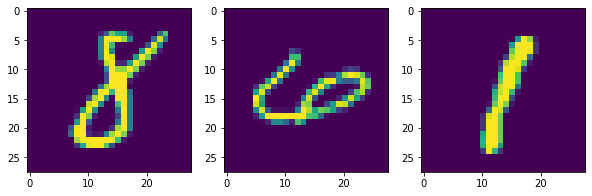

In [ ]:
sample_idx = 32
X_samples = X_train[sample_idx:sample_idx+3]
y_samples = y_train[sample_idx:sample_idx+3]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
ax[0].imshow(X_samples[0].reshape(28,28))
ax[1].imshow(X_samples[1].reshape(28,28))
ax[2].imshow(X_samples[2].reshape(28,28))

어텐션의 목적은 숫자를 예측하기 위해 이미지의 어느 부분에 집중해야하는지 결정하는 것입니다. mnist 데이터 셋은 숫자가 이미지 정중앙에 가지런히 놓여있는 매우 잘 정리된 데이터 셋이므로 이 상태로 어텐션을 적용하는 것은 큰 의미가 없을 수 있습니다. 실제로 `relu()` 활성함수를 사용한 가장 기본적인 MLP도 mnist 데이터 셋에서 정확도 98%를 달성합니다. 우리 목적은 높은 정확도를 달성하는 것이 아니라 mnist 분류 문제에서 어텐션의 효과를 확인하는 것입니다. 그래서 무작위로 숫자의 크기를 줄이고 위치를 구석구석 의도적으로 옮겨서 분류 작업의 난이도를 높일 필요가 있습니다. 이 작업을 위해 `albumentaions` 라이브러리를 사용합니다.

In [ ]:
import matplotlib.gridspec as gridspec

(3, 28, 28)
(3, 4, 4, 7, 7)


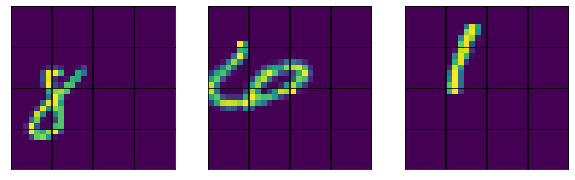

In [ ]:
# https://github.com/albumentations-team/albumentations#a-simple-example
# (0,1.0)사이로 그 정도를 지정할 수 있는 shift, scale, ratate를 설정한다.
# scale_limit에서 음수는 축소를 의미, 따라서 확대는 하지 않고 축소만 한다.
transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.3, scale_limit=(-0.4, 0), 
                       rotate_limit=0, p=0.8, border_mode=cv2.BORDER_CONSTANT)
])

# Augment an image
transformed_image = np.array(
        [transform(image=X_sample.reshape(28,28).astype(np.float32))["image"] 
        for X_sample in X_samples])
print(transformed_image.shape)

X_blocked = blockshaped(transformed_image, 7, 7)
print(X_blocked.shape)

# https://stackoverflow.com/questions/34933905/matplotlib-adding-subplots-to-a-subplot
fig = plt.figure(figsize=(10, 3))
outer = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.2)

for i in range(3):
    inner = gridspec.GridSpecFromSubplotSpec(4, 4, subplot_spec=outer[i],
                                             wspace=0., hspace=0.)
    
    for j in range(4):
        for k in range(4):
            ax = plt.Subplot(fig, inner[j,k])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(X_blocked[i,j,k])
            fig.add_subplot(ax)

plt.show()



의도한것처럼 숫자가 약간 작아지고 위치가 무작위로 이동된 것을 확인할 수 있습니다. 또 각 개별 이미지가 7x7 사이즈로 분할되어 전체 패치가 4x4인 것도 확인할 수 있습니다.

이제 이렇게 잘린 각 패치 열여섯개를 각디 다른 `Linear(49, 16)`에 입력합니다. 그 다음 출력으로 나온 길이 16짜리 벡터 열여섯개를 이어 붙여 전체 길이 256짜리 벡터로 만듭니다. 이 벡터를 `Linear(256,10)`에 입력하여 길이 10인 최종 출력 벡터를 만들도록 하겠습니다.

이제 준비가 끝났으니 모두 모아서 실제로 학습을 해보도록 합시다.


### Dataset 정의

`pytorch`를 사용하므로 앞서 테스트한 코드를 Dataset 클래스에 모두 구현합니다. 구현은 간단합니다. 초기화 작업을하고 `__getitem()__`에 이미지 증간 코드를 구현하면 끝납니다.

In [ ]:
class MnistDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.transform = transform
        # csv파일을 읽어서 이미지와 타겟을 준비한다.
        D = pd.read_csv(csv_file)
        self.X = D.iloc[:, 1:].to_numpy().reshape(D.shape[0], 28, 28) /255. # (N,28,28)
        self.y = D.iloc[:, 0]  # (N,)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        X_train = self.X[idx]
        y_train = self.y[idx]

        # transform이 초기화 되어있다면 이미지를 반환하기 전에
        # 이미지 증강 작업을 한다.
        if self.transform:
            transformed = transform(image=X_train)
            X_train = transformed["image"]

        return { "image": torch.tensor(X_train, dtype=torch.float),
                "target": torch.tensor(y_train, dtype=torch.long) }

### Dataset 테스트

간단하게 정의된 Dataset이 잘 동작하는지 실험해봅시다.

In [ ]:
transform = A.Compose([
A.ShiftScaleRotate(shift_limit=0.3, scale_limit=(-0.4, 0), 
                       rotate_limit=0, p=0.8, border_mode=cv2.BORDER_CONSTANT)
])

train_dataset = MnistDataset("sample_data/mnist_train_small.csv", 
                             transform=transform)

Dataset 객체를 생성하고 특정 인덱스로 데이터가 뽑혀나오는지 또 오그먼테이션이 되는지 확인하면 됩니다.

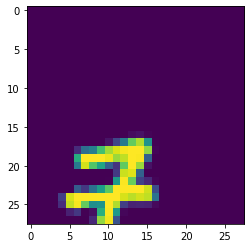

In [ ]:
X = train_dataset[11]
plt.imshow(X['image'])

나쁘지 않게 되는것 같네요. 그럼 이제 DataLoader를 만들고 미니배치가 제대로 생성되는지 확인합시다.

## DataLoader를 이용한 미니배치 테스트

아래 코드는 배치사이즈 10으로 DataLoader를 만들고 배치 4개를 뽑아보는 코드입니다. 한 배치의 텐서 크기는 (10, 28, 28)이 되어야합니다.

torch.Size([10, 28, 28])
torch.Size([10, 28, 28])
torch.Size([10, 28, 28])
torch.Size([10, 28, 28])


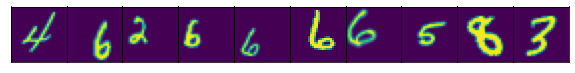

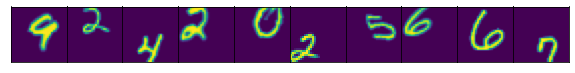

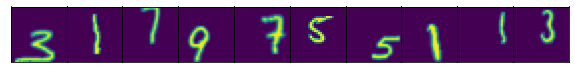

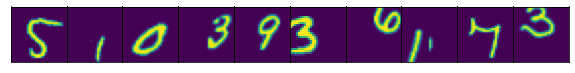

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

for i_batch, mini_batch in enumerate(train_loader):
    print(mini_batch['image'].shape)

    fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))
    fig.subplots_adjust(hspace=0, wspace=0)

    for j in range(10):
        ax[j].xaxis.set_major_locator(plt.NullLocator())
        ax[j].yaxis.set_major_locator(plt.NullLocator())
        ax[j].imshow(mini_batch['image'][j])

    if i_batch == 3:
        break


이미지 열개로 구성된 미니배치 4개에서 숫자를 보면 크기도 적당히 변하고 위치도 구석 구석으로 잘 배치되는 것을 확인할 수 있습니다. 이렇게 데이터 로딩 부분을 완성했으니 모델을 정의하고 학습하는 일만 남았습니다.

## 모델 만들기

모델은 어텐션이 없는 기본 모델과 있는 것 두개를 만들겠습니다. `Mnist`와 `MnistAttn`입니다. 각 모델은 열여섯개 패치에 적용되는 `Lienar()` 열여섯개를 `nn.ModuleList` 에 담아 가지고 있습니다. `Mnist`모델은 앞서 제시한 모식도를 그대로 코드로 옮긴것입니다. 모델에 대한 상세한 설명은 코드의 주석을 참고하시면 됩니다.

In [ ]:
class Mnist(nn.Module):
    def __init__(self, image_size, patch_size, hidden_patch, n_class):
        """
        이미지와 패치는 정사각형
        image_size:   입력되는 쪼개지기 전의 원래 이미지 크기, 28
        patch_size:   이미지를 패치로 쪼갤때 패치 하나의 크기, 7
        hidden_patch: 각 패치에 적용되는 Linear층의 출력 개수, 16
        n_class:      클래스 수, 10
        """
        super(Mnist, self).__init__()

        self.patch_size = patch_size
        
        assert image_size % patch_size == 0, \
            "{} is not evenly divisble by {}".format(image_size, patch_size)

        self.n_patch = image_size // patch_size # 4
        self.blocked_linears = torch.nn.ModuleList([ 
                                    nn.Linear(patch_size**2, hidden_patch) 
                                    for i in range(self.n_patch**2) ])

        self.hidden = nn.Linear(self.n_patch**2 * hidden_patch, n_class)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        """
        x : (N, n_patch_rows, n_patch_cols, patch_rows, patch_cols)
        """
        # 주석은 미니배치 10, 이미지사이즈가 (28,28), 패치사이즈가 (7,7)
        # 패치가 Linear()를 통과한후 나오는 출력이 16인 경우를 가정한다.
        # 주석에서
        # N: 배치 사이즈
        N, _, _, Pr, Pc = x.shape

        # forward는 분할된 이미지를 입력받는다. 이 경우 입력은 (10, 4, 4, 7, 7)
        # 4x4개 패치를 16개 한 차원으로 몰아넣는다.
        x = x.reshape(N, -1, Pr, Pc) # (N, 16, 7, 7) 

        # (7,7)인 개볖 패치를 한줄로 편다 
        x = x.reshape(N, self.n_patch**2, self.patch_size**2) # (N, 16, 49), 
        
        # ModuleList에 저장된 Linear() 열여섯개를 순차적으로 포워드시킨다.
        # 그 열여섯개 결과를 1번축으로 이어붙인다.
        blocks = torch.cat( [ linear_i(x[:, i]) 
                for i, linear_i in enumerate(self.blocked_linears) ], dim=1) # (N, 16*16)

        x = nn.functional.relu(blocks) # (N, 256)->(N, 256)  
        x = self.hidden(x) # (N, 256)->(N,10)
        x = self.logsoftmax(x) # (N,10)->(N,10)
        
        return x

        

위 기본 모델의 코드를 이해했다면 조금 복잡해지긴 하지만 `MnistAttn` 모델도 어렵지 않게 이해할 수 있습니다. 코드로 바로 이해하기 힘들 수도 있기 때문에 전체 개요를 아래 그림 2로 나타냈습니다.

![picture](https://drive.google.com/uc?id=1lF_x172N2tVUKfcs9-RAW3zyoN2VlTkm)
그림 2: Mnist 어텐션 개요


열여섯개로 잘린 패치를 각각 두개의 `Lienar()`층으로 입력합니다. 하나는 길이 16짜리 히든 벡터를 만들고, 하나는 어텐션 가중치를 계산하기 위해 숫자 하나를 만듭니다. `Linear(49,1)`에 의해 만들어진 숫자 열여섯개를 소프트맥스로 입력하여 가중치로 만들어 줍니다. 이후 `Lieaner(49,16)`에 의해 만들어진 길이 16짜리 벡터에 해당 가중치를 곱하고 이를 이어붙입니다. 이렇게 만들어진 최종 벡터를 다시 `Linear(256, 10)`에 통과시켜 최종 클래스 확률이 될 로짓벡터를 만들어내게 됩니다. 

In [ ]:
class MnistAttn(nn.Module):
    def __init__(self, image_size, patch_size, hidden_patch, n_class):
        """
        이미지와 패치는 정사각형
        image_size:   입력되는 쪼개지기 전의 원래 이미지 크기, 28
        patch_size:   이미지를 패치로 쪼갤때 패치 하나의 크기, 7
        hidden_patch: 각 패치에 적용되는 Linear층의 출력 개수, 16
        n_class:      클래스 수, 10
        """
        super(MnistAttn, self).__init__()

        self.patch_size = patch_size
        self.hidden_patch = hidden_patch
        self.alpha = None # attention weights
        
        assert image_size % patch_size == 0, \
            "{} is not evenly divisble by {}".format(image_size, patch_size)

        self.n_patch = image_size // patch_size # 4
        # 16 (49, 16)
        self.blocked_linears = torch.nn.ModuleList([ 
                                    nn.Linear(patch_size**2, hidden_patch) 
                                    for i in range(self.n_patch**2) ])
        # 16 (49, 1)
        self.attns = torch.nn.ModuleList([
                                    nn.Linear(patch_size**2, 1)
                                    for i in range(self.n_patch**2) ])
        # (256, 10)
        self.hidden = nn.Linear(self.n_patch**2 * hidden_patch, n_class)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        """
        x : (N, n_patch_rows, n_patch_cols, patch_rows, patch_cols)
        """
        # 주석은 미니배치 10, 이미지사이즈가 (28,28), 패치사이즈가 (7,7)
        # 패치가 Linear()를 통과한후 나오는 출력이 16인 경우를 가정한다.
        # 주석에서
        # N: 배치 사이즈
        # o: 패치를 입력받는 Linear의 출력 사이즈
        # l: 패치 개수
        N, _, _, Pr, Pc = x.shape

        x = x.reshape(N, -1, Pr, Pc) # (N, 16, 7, 7)
        x = x.reshape(N, self.n_patch**2, self.patch_size**2) # (N, 16, 49)
        
        blocks = ( torch.cat([ nn.functional.relu(linear_i(x[:, i])) # (N, o) * l, (N, 16) * 16
                    for i, linear_i in enumerate(self.blocked_linears) ], dim=0)
                    .reshape(-1, N, self.hidden_patch).transpose(1,0) ) # (N, l, o), (N, 16, 16) 
        
        attn_weights = torch.cat( [ torch.tanh(attn_i(x[:, i])) 
                for i, attn_i in enumerate(self.attns) ], dim=1)
        attn_weights = nn.functional.softmax(attn_weights, dim=1) # (N, l), (N, 16)
        self.alpha = attn_weights
        attn_weights = torch.unsqueeze(attn_weights, 2) # (N, l, 1), (N, 16, 1)

        x = blocks * attn_weights # (N,l,o)*(N,l,1)=(N, 16, 16)*(N, 16, 1)=(N, 16, 16)
        
        # reshape (N, 16, 16) -> (N, 16*16)
        x = x.reshape(N,-1)
        
        x = self.hidden(x) # (N,10)
        x = self.logsoftmax(x)
        
        return x


이 모델같은 경우 `forward`함수에서 `reshape`하는 부분이 조금 복잡합니다. 그림2와 주석에 적혀있는 텐서의 모양을 잘 살펴보고 이해해보도록 합시다. 먼저 각 패치를 포워드 시키는 부분입니다. 

주석에서 패치 개수는 `l`은 값으로 16을 가지고, 패치를 입려받는 `Linear()`의 출력은 `o`도 16입니다.

```python
blocks = ( torch.cat([ nn.functional.relu(linear_i(x[:, i])) # (N, o) * l, (N, 16) * 16
                    for i, linear_i in enumerate(self.blocked_linears) ], dim=0)
                    .reshape(-1, N, self.hidden_patch).transpose(1,0) ) # (N, l, o), (N, 16, 16) 
```

위 코드는 패치를 입력으로 받는 열여섯개 `Linear()`를 순환하면서 패치 열여섯개를 순차적으로 입력시키는 코드입니다. 위 코드에서 가장 안쪽부분에 해당합니다.


```python
[ nn.functional.relu(linear_i(x[:, i])) # (N, o) * l, (N, 16) * 16
                    for i, linear_i in enumerate(self.blocked_linears) ]
```

현재 `x`는 N=10개 샘플이 모두 들어 있으므로 (10, 16, 49)입니다. 그림 3에 `x`를 나타냈습니다.

![picture](https://drive.google.com/uc?id=14ozlWpBz5M3UXKLX1ux4F1XDrCWi7b9G)
그림 3: 미니배치 `x`

리스트 컴프리헨션으로 열여섯번 반복하면서 `x[:,i]`를 `i`번째 `Linear()`로 입력하고 있습니다. `x[:,i]`는 아래 그림 4처럼 (10, 49)입니다.

![picture](https://drive.google.com/uc?id=1hhevqpv7nZh9eM-tTuscyIO5LHMmpHWu)
그림 4: 첫번째 `Linear()`로 입력되는 미니배치 `x`에서 텐서 `x[:,0]`

그림 4에서 `x[:,0]`은 미니배치안에 있는 10개 샘플의 첫번째 패치입니다. 이렇게 10개 샘플에 대한 패치 열여섯개를 지정할 수 있습니다. 이것을 순차적으로 포워드시키는 리스트 컴프리헨션을 수행하고 나면 (10, 16)인 텐서를 열여섯개 가지고 있는 리스트가 만들어 집니다. 이제 이 리스트를 `dim=0`번 방향으로 `cat` 시킵니다.




그림 5는 `cat` 이후로 진행되는 후반부를 그림으로 나타낸 것입니다.

![picture](https://drive.google.com/uc?id=1g7g6Gt8-r4s5e06Ol7Rgv4BYy2vnMy4I)
그림 5: 패치를 포워드시키는 후반 과정

이 과정들을 거치게 되면 `blocks`에는 0번 차원으로 샘플들이 놓이고, 1번 차원으로는 패치들이 2번 차원으로는 `Linear()`에 의해 계산된 출력값들이 놓이게 됩니다. 진행과정에서 샘플들의 개수 N, 출력 `o`, 패치 개수 `l`이 어떤 방향으로 놓이는지 눈여겨 봐야합니다. 그림에서 굵게 표시한 행들이 첫번째 샘플에 해당하는 값들입니다.

다음은 그림 2처럼 패치로 부터 어텐션 가중치를 구해야 합니다. 우선 다음 코드로 패치로부터 값 하나를 뽑아냅니다. 여기서는 `Linear()`를 통과한후 활성함수로 `tanh()`를 사용하였습니다.

```python
attn_weights = torch.cat( [ torch.tanh(attn_i(x[:, i])) 
                for i, attn_i in enumerate(self.attns) ], dim=1)

attn_weights = nn.functional.softmax(attn_weights, dim=1) # (N, l), (N, 16)
attn_weights = torch.unsqueeze(attn_weights, 2) # (N, l, 1), (N, 16, 1)
```

코드를 보면 어텐션 가중치를 구할때도 이전과 같은 방식을 사용합니다. 각 패치를 입력받는 `Linear()`의 출력 크기가 1이라는 것만 제외하면 일단 동일하게 진행하고 `torch.cat()`시킬 때 축방향만 1로 지정합니다. 그러면 아래 그림처럼 될 것입니다. 

![picture](https://drive.google.com/uc?id=1s46wJ_cu6nkG5OLTKdxC68ZhL_Ovmsy_)

그림 6: 어텐션 가중치를 구하기 위한 과정

`torch.cat()`후 `dim=1`로 소프트맥스를 적용하여 계산된 값을 가중치화 합니다. 그리고 마지막에 차원을 하나추가하여 그림 6처럼 계산된 값들이 놓이게 합니다. 이제 계산된 가중치를 앞서 계산해둔 `blocks`에 곱하기만 하면 됩니다.

이미 브로드캐스팅이 되게 차원을 맞춰놓았으므로 그냥 곱하기만 하면됩니다. 그림 7은 이 곱셈이 어떻게 수행되는지 자세히 나타낸 것입니다.

```python
x = blocks * attn_weights # (N,l,o)*(N,l,1)=(N, 16, 16)*(N, 16, 1)=(N, 16, 16)
```

![picture](https://drive.google.com/uc?id=16LyJQWdZDtxXZKtN45-U69o-taQwYv0l)
그림 7: 계산된 가중치와 `blocks`의 브로드캐스팅 곱셈

샘플 하나에서 잘린 열여섯개 블록으로 부터 계산된 값들(그림 7에서 곱셈 왼쪽에 있는 굵게 표시된 행들)에 동일한 어텐션 가중치들(그림 오른쪽에 굵게 표시된 행들)이 브로드캐스팅을 통해 한번에 곱해지게 됩니다. 그림 7에서 `attn_wieghts`에 표시된 굵게 표시된 행들은 모두 같은 값들임을 주의해야 합니다. 즉 하나의 패치에 모두 같은 가중치를 곱해주는 것입니다. 

미니배치가 추가되면서 텐서를 다루는 과정이 약간 복잡해졌지만 이 과정만 지나면 나머지는 보통 MLP를 포워드시키는 과정과 동일합니다.


### 포워드 테스트

모델 설계가 끝났으므로 이 모델이 데이터를 제대로 포워드 시키는지 실험해봅시다. DataLoader로 부터 미니배치 하나를 얻어와서 모델에 입력하고 포워드시킵니다. 결과로는 두 모델 모두 (10, 10)인 텐서가 나와야 합니다.

In [ ]:
# 데이터 로더로 부터 미니배치 하나 얻어오기
train_loader_iter = iter(train_loader)
batch = train_loader_iter.next()
# print(batch['image'].shape)

# 미니배치를 7x7 패치로 자르기
blocked_batch = torch.tensor(blockshaped(batch['image'].numpy(), 7, 7))
# print(blocked_batch.shape)

# 포워드 시키기
model = Mnist(28, 7, 17, 10)
model.cuda()

model_attn = MnistAttn(28, 7, 16, 10)
model_attn.cuda()

blocked_batch = blocked_batch.cuda()

out = model(blocked_batch)
print(out.shape)

out = model_attn(blocked_batch)
print(out.shape)

torch.Size([10, 10])
torch.Size([10, 10])


두 모델 모두 (10,10)인 텐서를 출력하고 있습니다. 하나 언급하고 넘어갸야 할 것은 두 모델을 생성할 때 패치를 입력받는 `Linear()`의 출력 개수가 다르다는 것입니다. 어텐션을 주는 경우 학습할 수 있는 파라미터가 늘어나므로 파리미터 수에 대한 학습효과를 무사히기위해 두 모델의 파라미터 수를 최대한 동일하게 맞추는 것이 좋습니다. 기본 모델은 출력 개수를 17로 하나 더 크게 하였습니다. 실제 두 모델의 파라미터 수를 비교 해보면




In [ ]:
no_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
no_model_attn_params = sum(p.numel() for p in model_attn.parameters() if p.requires_grad)

print(f"no. of model params without attention : {no_model_params}")
print(f"no. of model params with attention    : {no_model_attn_params}")
print(f"no_model_attn_params - no_model_params: {no_model_attn_params - no_model_params}")

no. of model params without attention : 16330
no. of model params with attention    : 16170
no_model_attn_params - no_model_params: -160


위 처럼 기본 모델이 어텐션이 있는 모델보다 파라미터 수가 160개 더 많습니다. 어텐션 모델의 결과가 더 좋다면 적어도 어텐션 모델이 파라미터가 더 많아서 생긴 결과는 아니라고 할 수 있습니다.

### 학습

위에서 적용한 이미지 증강 기법을 똑같이 적용하여 학습과 테스트 데이터로더를 만듭니다.

In [ ]:
batch_size = 10

# transform = A.Compose([
#     A.ShiftScaleRotate(shift_limit=0.3, scale_limit=(0, 0), 
#                        rotate_limit=0, p=0.8)
# ])

transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.3, scale_limit=(-0.4, 0), 
                       rotate_limit=0, p=0.8, border_mode=cv2.BORDER_CONSTANT)
])

train_dataset = MnistDataset("sample_data/mnist_train_small.csv", 
                             transform=transform)
print(len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          num_workers=4, shuffle=True, pin_memory=True)

test_dataset = MnistDataset("sample_data/mnist_test.csv",
                            transform=transform)
print(len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         num_workers=4, shuffle=True, pin_memory=True)

19999
9999


손실함수, 에폭과 학습률을 정의합니다. 모델이 최종적으로 소프트맥스에 로그를 적용한 값을 반환하므로 손실함수는 `NLLLoss()`를 사용합니다. 에폭을 꽤 크게 잡은 것은 기본 모델은 에폭이 진행되어도 결과가 개선되지 않지만 어텐션이 있는 모델은 지속적으로 결과가 개선되는 것을 확인하기 위해서 입니다.

In [ ]:
criterion = nn.NLLLoss()
epoches = 250
lr = 0.3

model = Mnist(28, 7, 17, 10)
model.cuda()

model_attn = MnistAttn(28, 7, 16, 10)
model_attn.cuda()

MnistAttn(
  (blocked_linears): ModuleList(
    (0): Linear(in_features=49, out_features=16, bias=True)
    (1): Linear(in_features=49, out_features=16, bias=True)
    (2): Linear(in_features=49, out_features=16, bias=True)
    (3): Linear(in_features=49, out_features=16, bias=True)
    (4): Linear(in_features=49, out_features=16, bias=True)
    (5): Linear(in_features=49, out_features=16, bias=True)
    (6): Linear(in_features=49, out_features=16, bias=True)
    (7): Linear(in_features=49, out_features=16, bias=True)
    (8): Linear(in_features=49, out_features=16, bias=True)
    (9): Linear(in_features=49, out_features=16, bias=True)
    (10): Linear(in_features=49, out_features=16, bias=True)
    (11): Linear(in_features=49, out_features=16, bias=True)
    (12): Linear(in_features=49, out_features=16, bias=True)
    (13): Linear(in_features=49, out_features=16, bias=True)
    (14): Linear(in_features=49, out_features=16, bias=True)
    (15): Linear(in_features=49, out_features=16, b

학습 함수를 적당히 만들고...

In [ ]:
def train(model, acc):
    
    for epoch in range(epoches):
        cur_loss = 0
        correct = 0
        for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            X = data['image']
            y = data['target']

            # 미니배치를 7x7 패치로 자르기
            X = torch.tensor(blockshaped(X.numpy(), 7, 7))
            
            X = X.cuda()
            y = y.cuda()
            
            # optimizer를 쓰지 않으면 model에 params가 있으므로 model에서 
            # 그래디언트 초기화
            model.zero_grad()
            out = model(X)
            
            loss = criterion(out, y)
            loss.backward()

            # 옵티마이저를 쓰지 않으므로 직접 params 업데이트
            for p in model.parameters():
                p.data.add_(p.grad.data, alpha = -lr)
            
            correct += (torch.exp(out).argmax(axis=1) == y).float().sum()
            cur_loss += loss

        acc_train = 100. * correct / len(train_dataset)

        # test acc.
        with torch.no_grad():
            correct = 0
            for i, data in enumerate(test_loader):
                X = data['image']
                y = data['target']

                X = torch.tensor(blockshaped(X.numpy(), 7, 7), device="cuda:0")
                # X = X.cuda()
                y = y.cuda()

                out = model(X)
                correct += (torch.exp(out).argmax(axis=1) == y).float().sum()
        acc_test = 100. * correct / len(test_dataset)

        print(f"EPOCH: {(epoch+1):02d}, LOSS: {cur_loss.item()/i:e}, TRAIN ACC.: {acc_train:e}, TEST ACC.: {acc_test:e}")
        
        acc['train'].append(acc_train.item())
        acc['test'].append(acc_test.item())


두 모델을 학습합니다.

In [ ]:
model_acc = {'train':[], 'test':[]}

train(model, model_acc)

100%|██████████| 2000/2000 [00:09<00:00, 216.35it/s]


EPOCH: 01, LOSS: 3.731289e+00, TRAIN ACC.: 3.469674e+01, TEST ACC.: 4.587459e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.76it/s]


EPOCH: 02, LOSS: 2.909303e+00, TRAIN ACC.: 5.000250e+01, TEST ACC.: 5.256526e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.35it/s]


EPOCH: 03, LOSS: 2.631861e+00, TRAIN ACC.: 5.503275e+01, TEST ACC.: 5.815582e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.52it/s]


EPOCH: 04, LOSS: 2.465901e+00, TRAIN ACC.: 5.809291e+01, TEST ACC.: 6.031603e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.91it/s]


EPOCH: 05, LOSS: 2.379569e+00, TRAIN ACC.: 5.998800e+01, TEST ACC.: 5.968597e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.32it/s]


EPOCH: 06, LOSS: 2.302785e+00, TRAIN ACC.: 6.139307e+01, TEST ACC.: 6.304631e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.65it/s]


EPOCH: 07, LOSS: 2.217470e+00, TRAIN ACC.: 6.312316e+01, TEST ACC.: 6.393639e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.91it/s]


EPOCH: 08, LOSS: 2.225608e+00, TRAIN ACC.: 6.303815e+01, TEST ACC.: 6.407641e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.10it/s]


EPOCH: 09, LOSS: 2.202487e+00, TRAIN ACC.: 6.360818e+01, TEST ACC.: 6.536654e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.80it/s]


EPOCH: 10, LOSS: 2.169960e+00, TRAIN ACC.: 6.403320e+01, TEST ACC.: 6.604661e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.30it/s]


EPOCH: 11, LOSS: 2.128699e+00, TRAIN ACC.: 6.541827e+01, TEST ACC.: 6.500650e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.96it/s]


EPOCH: 12, LOSS: 2.098907e+00, TRAIN ACC.: 6.559328e+01, TEST ACC.: 6.594659e+01


100%|██████████| 2000/2000 [00:09<00:00, 219.90it/s]


EPOCH: 13, LOSS: 2.100924e+00, TRAIN ACC.: 6.588329e+01, TEST ACC.: 6.588659e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.96it/s]


EPOCH: 14, LOSS: 2.079337e+00, TRAIN ACC.: 6.617331e+01, TEST ACC.: 6.682668e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.51it/s]


EPOCH: 15, LOSS: 2.060003e+00, TRAIN ACC.: 6.611831e+01, TEST ACC.: 6.630663e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.41it/s]


EPOCH: 16, LOSS: 2.052058e+00, TRAIN ACC.: 6.673834e+01, TEST ACC.: 6.868687e+01


100%|██████████| 2000/2000 [00:08<00:00, 227.45it/s]


EPOCH: 17, LOSS: 2.011510e+00, TRAIN ACC.: 6.756838e+01, TEST ACC.: 6.787679e+01


100%|██████████| 2000/2000 [00:09<00:00, 217.36it/s]


EPOCH: 18, LOSS: 2.035206e+00, TRAIN ACC.: 6.730836e+01, TEST ACC.: 6.847684e+01


100%|██████████| 2000/2000 [00:09<00:00, 222.04it/s]


EPOCH: 19, LOSS: 1.980543e+00, TRAIN ACC.: 6.771839e+01, TEST ACC.: 6.830683e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.36it/s]


EPOCH: 20, LOSS: 1.993848e+00, TRAIN ACC.: 6.762838e+01, TEST ACC.: 6.690669e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.59it/s]


EPOCH: 21, LOSS: 2.010355e+00, TRAIN ACC.: 6.766839e+01, TEST ACC.: 6.745675e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.47it/s]


EPOCH: 22, LOSS: 1.985507e+00, TRAIN ACC.: 6.770338e+01, TEST ACC.: 6.903690e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.09it/s]


EPOCH: 23, LOSS: 1.960975e+00, TRAIN ACC.: 6.853843e+01, TEST ACC.: 6.877688e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.27it/s]


EPOCH: 24, LOSS: 1.950667e+00, TRAIN ACC.: 6.844843e+01, TEST ACC.: 6.882688e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.23it/s]


EPOCH: 25, LOSS: 1.981797e+00, TRAIN ACC.: 6.845342e+01, TEST ACC.: 6.930693e+01


100%|██████████| 2000/2000 [00:08<00:00, 232.97it/s]


EPOCH: 26, LOSS: 1.959711e+00, TRAIN ACC.: 6.860843e+01, TEST ACC.: 6.904691e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.60it/s]


EPOCH: 27, LOSS: 1.979081e+00, TRAIN ACC.: 6.831842e+01, TEST ACC.: 6.900690e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.28it/s]


EPOCH: 28, LOSS: 1.944497e+00, TRAIN ACC.: 6.850843e+01, TEST ACC.: 6.966697e+01


100%|██████████| 2000/2000 [00:08<00:00, 227.27it/s]


EPOCH: 29, LOSS: 1.940470e+00, TRAIN ACC.: 6.855343e+01, TEST ACC.: 6.920692e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.29it/s]


EPOCH: 30, LOSS: 1.966698e+00, TRAIN ACC.: 6.829842e+01, TEST ACC.: 6.794679e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.26it/s]


EPOCH: 31, LOSS: 1.949352e+00, TRAIN ACC.: 6.852343e+01, TEST ACC.: 6.856686e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.55it/s]


EPOCH: 32, LOSS: 1.942075e+00, TRAIN ACC.: 6.883845e+01, TEST ACC.: 6.813682e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.44it/s]


EPOCH: 33, LOSS: 1.917690e+00, TRAIN ACC.: 6.939347e+01, TEST ACC.: 6.979698e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.51it/s]


EPOCH: 34, LOSS: 1.918429e+00, TRAIN ACC.: 6.944347e+01, TEST ACC.: 6.952695e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.24it/s]


EPOCH: 35, LOSS: 1.922337e+00, TRAIN ACC.: 6.916346e+01, TEST ACC.: 6.933694e+01


100%|██████████| 2000/2000 [00:09<00:00, 220.84it/s]


EPOCH: 36, LOSS: 1.918252e+00, TRAIN ACC.: 6.911346e+01, TEST ACC.: 7.114712e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.33it/s]


EPOCH: 37, LOSS: 1.906365e+00, TRAIN ACC.: 6.971849e+01, TEST ACC.: 6.945695e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.83it/s]


EPOCH: 38, LOSS: 1.907369e+00, TRAIN ACC.: 6.937347e+01, TEST ACC.: 7.082708e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.53it/s]


EPOCH: 39, LOSS: 1.931056e+00, TRAIN ACC.: 6.898845e+01, TEST ACC.: 6.868687e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.66it/s]


EPOCH: 40, LOSS: 1.889476e+00, TRAIN ACC.: 6.891845e+01, TEST ACC.: 7.014702e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.93it/s]


EPOCH: 41, LOSS: 1.907697e+00, TRAIN ACC.: 6.977849e+01, TEST ACC.: 6.986699e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.24it/s]


EPOCH: 42, LOSS: 1.887939e+00, TRAIN ACC.: 6.971849e+01, TEST ACC.: 6.993700e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.39it/s]


EPOCH: 43, LOSS: 1.901156e+00, TRAIN ACC.: 6.929847e+01, TEST ACC.: 7.029703e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.59it/s]


EPOCH: 44, LOSS: 1.868308e+00, TRAIN ACC.: 7.004851e+01, TEST ACC.: 6.920692e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.82it/s]


EPOCH: 45, LOSS: 1.910672e+00, TRAIN ACC.: 6.933347e+01, TEST ACC.: 6.944695e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.36it/s]


EPOCH: 46, LOSS: 1.896168e+00, TRAIN ACC.: 6.976349e+01, TEST ACC.: 6.998700e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.31it/s]


EPOCH: 47, LOSS: 1.889934e+00, TRAIN ACC.: 6.985850e+01, TEST ACC.: 6.999700e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.84it/s]


EPOCH: 48, LOSS: 1.892324e+00, TRAIN ACC.: 7.001350e+01, TEST ACC.: 6.990699e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.79it/s]


EPOCH: 49, LOSS: 1.891940e+00, TRAIN ACC.: 6.995850e+01, TEST ACC.: 7.154716e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.60it/s]


EPOCH: 50, LOSS: 1.867570e+00, TRAIN ACC.: 7.010851e+01, TEST ACC.: 7.065707e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.27it/s]


EPOCH: 51, LOSS: 1.896047e+00, TRAIN ACC.: 6.980849e+01, TEST ACC.: 6.854685e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.29it/s]


EPOCH: 52, LOSS: 1.871364e+00, TRAIN ACC.: 6.993350e+01, TEST ACC.: 7.067707e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.95it/s]


EPOCH: 53, LOSS: 1.861327e+00, TRAIN ACC.: 7.040352e+01, TEST ACC.: 6.921692e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.18it/s]


EPOCH: 54, LOSS: 1.872303e+00, TRAIN ACC.: 6.988350e+01, TEST ACC.: 6.989699e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.86it/s]


EPOCH: 55, LOSS: 1.859974e+00, TRAIN ACC.: 6.993350e+01, TEST ACC.: 7.065707e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.51it/s]


EPOCH: 56, LOSS: 1.881103e+00, TRAIN ACC.: 6.994850e+01, TEST ACC.: 7.107711e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.50it/s]


EPOCH: 57, LOSS: 1.842840e+00, TRAIN ACC.: 7.037852e+01, TEST ACC.: 7.071707e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.82it/s]


EPOCH: 58, LOSS: 1.875571e+00, TRAIN ACC.: 6.976849e+01, TEST ACC.: 7.134714e+01


100%|██████████| 2000/2000 [00:09<00:00, 218.46it/s]


EPOCH: 59, LOSS: 1.855332e+00, TRAIN ACC.: 7.001350e+01, TEST ACC.: 6.899690e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.62it/s]


EPOCH: 60, LOSS: 1.884997e+00, TRAIN ACC.: 6.980849e+01, TEST ACC.: 6.996700e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.07it/s]


EPOCH: 61, LOSS: 1.824539e+00, TRAIN ACC.: 7.086355e+01, TEST ACC.: 6.855685e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.87it/s]


EPOCH: 62, LOSS: 1.868501e+00, TRAIN ACC.: 7.038352e+01, TEST ACC.: 6.985699e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.62it/s]


EPOCH: 63, LOSS: 1.826992e+00, TRAIN ACC.: 7.077854e+01, TEST ACC.: 7.022702e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.39it/s]


EPOCH: 64, LOSS: 1.881962e+00, TRAIN ACC.: 6.997350e+01, TEST ACC.: 6.970697e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.13it/s]


EPOCH: 65, LOSS: 1.844940e+00, TRAIN ACC.: 7.081355e+01, TEST ACC.: 6.996700e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.15it/s]


EPOCH: 66, LOSS: 1.828749e+00, TRAIN ACC.: 7.098355e+01, TEST ACC.: 7.046705e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.30it/s]


EPOCH: 67, LOSS: 1.826186e+00, TRAIN ACC.: 7.088855e+01, TEST ACC.: 7.115712e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.82it/s]


EPOCH: 68, LOSS: 1.855360e+00, TRAIN ACC.: 7.012851e+01, TEST ACC.: 7.157716e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.78it/s]


EPOCH: 69, LOSS: 1.830411e+00, TRAIN ACC.: 7.101855e+01, TEST ACC.: 7.037704e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.66it/s]


EPOCH: 70, LOSS: 1.830049e+00, TRAIN ACC.: 7.045853e+01, TEST ACC.: 7.086709e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.86it/s]


EPOCH: 71, LOSS: 1.837952e+00, TRAIN ACC.: 7.041853e+01, TEST ACC.: 7.002700e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.84it/s]


EPOCH: 72, LOSS: 1.857097e+00, TRAIN ACC.: 7.048353e+01, TEST ACC.: 6.961696e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.16it/s]


EPOCH: 73, LOSS: 1.839251e+00, TRAIN ACC.: 7.060353e+01, TEST ACC.: 7.105711e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.25it/s]


EPOCH: 74, LOSS: 1.835646e+00, TRAIN ACC.: 7.053853e+01, TEST ACC.: 7.147715e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.45it/s]


EPOCH: 75, LOSS: 1.850898e+00, TRAIN ACC.: 7.030852e+01, TEST ACC.: 7.097710e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.71it/s]


EPOCH: 76, LOSS: 1.836961e+00, TRAIN ACC.: 7.054353e+01, TEST ACC.: 6.968697e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.87it/s]


EPOCH: 77, LOSS: 1.832445e+00, TRAIN ACC.: 7.072354e+01, TEST ACC.: 7.078708e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.94it/s]


EPOCH: 78, LOSS: 1.828653e+00, TRAIN ACC.: 7.076354e+01, TEST ACC.: 7.099710e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.80it/s]


EPOCH: 79, LOSS: 1.842517e+00, TRAIN ACC.: 7.046352e+01, TEST ACC.: 7.111711e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.09it/s]


EPOCH: 80, LOSS: 1.846411e+00, TRAIN ACC.: 7.079354e+01, TEST ACC.: 7.080708e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.93it/s]


EPOCH: 81, LOSS: 1.853102e+00, TRAIN ACC.: 7.015351e+01, TEST ACC.: 7.107711e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.35it/s]


EPOCH: 82, LOSS: 1.832917e+00, TRAIN ACC.: 7.071354e+01, TEST ACC.: 7.088709e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.49it/s]


EPOCH: 83, LOSS: 1.825462e+00, TRAIN ACC.: 7.103855e+01, TEST ACC.: 7.106711e+01


100%|██████████| 2000/2000 [00:09<00:00, 219.50it/s]


EPOCH: 84, LOSS: 1.827616e+00, TRAIN ACC.: 7.093855e+01, TEST ACC.: 7.097710e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.39it/s]


EPOCH: 85, LOSS: 1.828743e+00, TRAIN ACC.: 7.060353e+01, TEST ACC.: 6.986699e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.37it/s]


EPOCH: 86, LOSS: 1.849073e+00, TRAIN ACC.: 7.044353e+01, TEST ACC.: 7.110711e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.15it/s]


EPOCH: 87, LOSS: 1.826534e+00, TRAIN ACC.: 7.048853e+01, TEST ACC.: 7.079708e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.64it/s]


EPOCH: 88, LOSS: 1.828076e+00, TRAIN ACC.: 7.090855e+01, TEST ACC.: 7.106711e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.89it/s]


EPOCH: 89, LOSS: 1.867628e+00, TRAIN ACC.: 6.984850e+01, TEST ACC.: 7.068707e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.16it/s]


EPOCH: 90, LOSS: 1.831498e+00, TRAIN ACC.: 7.106355e+01, TEST ACC.: 7.078708e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.71it/s]


EPOCH: 91, LOSS: 1.808494e+00, TRAIN ACC.: 7.096855e+01, TEST ACC.: 7.037704e+01


100%|██████████| 2000/2000 [00:09<00:00, 220.27it/s]


EPOCH: 92, LOSS: 1.837397e+00, TRAIN ACC.: 7.025851e+01, TEST ACC.: 7.152715e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.58it/s]


EPOCH: 93, LOSS: 1.858195e+00, TRAIN ACC.: 7.029352e+01, TEST ACC.: 7.072707e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.26it/s]


EPOCH: 94, LOSS: 1.835774e+00, TRAIN ACC.: 7.086855e+01, TEST ACC.: 6.994700e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.32it/s]


EPOCH: 95, LOSS: 1.827532e+00, TRAIN ACC.: 7.090355e+01, TEST ACC.: 7.220722e+01


100%|██████████| 2000/2000 [00:08<00:00, 229.77it/s]


EPOCH: 96, LOSS: 1.804967e+00, TRAIN ACC.: 7.110355e+01, TEST ACC.: 7.050705e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.57it/s]


EPOCH: 97, LOSS: 1.819023e+00, TRAIN ACC.: 7.069854e+01, TEST ACC.: 7.165717e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.97it/s]


EPOCH: 98, LOSS: 1.820428e+00, TRAIN ACC.: 7.114356e+01, TEST ACC.: 7.003700e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.17it/s]


EPOCH: 99, LOSS: 1.829401e+00, TRAIN ACC.: 7.075354e+01, TEST ACC.: 7.132713e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.80it/s]


EPOCH: 100, LOSS: 1.845115e+00, TRAIN ACC.: 7.083354e+01, TEST ACC.: 7.083708e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.74it/s]


EPOCH: 101, LOSS: 1.843059e+00, TRAIN ACC.: 7.040352e+01, TEST ACC.: 7.054706e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.34it/s]


EPOCH: 102, LOSS: 1.803446e+00, TRAIN ACC.: 7.152858e+01, TEST ACC.: 7.152715e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.21it/s]


EPOCH: 103, LOSS: 1.821931e+00, TRAIN ACC.: 7.088354e+01, TEST ACC.: 7.062706e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.50it/s]


EPOCH: 104, LOSS: 1.824222e+00, TRAIN ACC.: 7.089355e+01, TEST ACC.: 7.069707e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.93it/s]


EPOCH: 105, LOSS: 1.816144e+00, TRAIN ACC.: 7.111856e+01, TEST ACC.: 7.206721e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.44it/s]


EPOCH: 106, LOSS: 1.813975e+00, TRAIN ACC.: 7.123357e+01, TEST ACC.: 7.095710e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.74it/s]


EPOCH: 107, LOSS: 1.810196e+00, TRAIN ACC.: 7.116856e+01, TEST ACC.: 7.074708e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.04it/s]


EPOCH: 108, LOSS: 1.799234e+00, TRAIN ACC.: 7.135857e+01, TEST ACC.: 7.076707e+01


100%|██████████| 2000/2000 [00:08<00:00, 230.85it/s]


EPOCH: 109, LOSS: 1.817145e+00, TRAIN ACC.: 7.117856e+01, TEST ACC.: 7.190719e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.20it/s]


EPOCH: 110, LOSS: 1.795745e+00, TRAIN ACC.: 7.103355e+01, TEST ACC.: 7.261726e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.55it/s]


EPOCH: 111, LOSS: 1.829245e+00, TRAIN ACC.: 7.086355e+01, TEST ACC.: 7.071707e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.08it/s]


EPOCH: 112, LOSS: 1.793290e+00, TRAIN ACC.: 7.116356e+01, TEST ACC.: 7.187719e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.12it/s]


EPOCH: 113, LOSS: 1.789163e+00, TRAIN ACC.: 7.168359e+01, TEST ACC.: 7.154716e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.56it/s]


EPOCH: 114, LOSS: 1.802295e+00, TRAIN ACC.: 7.161359e+01, TEST ACC.: 7.132713e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.31it/s]


EPOCH: 115, LOSS: 1.806343e+00, TRAIN ACC.: 7.108855e+01, TEST ACC.: 7.286729e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.85it/s]


EPOCH: 116, LOSS: 1.823295e+00, TRAIN ACC.: 7.110355e+01, TEST ACC.: 7.129713e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.78it/s]


EPOCH: 117, LOSS: 1.813596e+00, TRAIN ACC.: 7.111856e+01, TEST ACC.: 7.066707e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.20it/s]


EPOCH: 118, LOSS: 1.801501e+00, TRAIN ACC.: 7.124857e+01, TEST ACC.: 7.150715e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.23it/s]


EPOCH: 119, LOSS: 1.817020e+00, TRAIN ACC.: 7.098355e+01, TEST ACC.: 7.082708e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.40it/s]


EPOCH: 120, LOSS: 1.805028e+00, TRAIN ACC.: 7.120356e+01, TEST ACC.: 7.129713e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.28it/s]


EPOCH: 121, LOSS: 1.807024e+00, TRAIN ACC.: 7.115856e+01, TEST ACC.: 7.089709e+01


100%|██████████| 2000/2000 [00:08<00:00, 227.07it/s]


EPOCH: 122, LOSS: 1.785537e+00, TRAIN ACC.: 7.150358e+01, TEST ACC.: 7.083708e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.21it/s]


EPOCH: 123, LOSS: 1.775115e+00, TRAIN ACC.: 7.151858e+01, TEST ACC.: 7.196719e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.70it/s]


EPOCH: 124, LOSS: 1.827040e+00, TRAIN ACC.: 7.100855e+01, TEST ACC.: 7.098710e+01


100%|██████████| 2000/2000 [00:08<00:00, 227.01it/s]


EPOCH: 125, LOSS: 1.830654e+00, TRAIN ACC.: 7.067854e+01, TEST ACC.: 7.177718e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.13it/s]


EPOCH: 126, LOSS: 1.831091e+00, TRAIN ACC.: 7.064854e+01, TEST ACC.: 7.113712e+01


100%|██████████| 2000/2000 [00:09<00:00, 220.85it/s]


EPOCH: 127, LOSS: 1.783618e+00, TRAIN ACC.: 7.160858e+01, TEST ACC.: 7.140714e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.90it/s]


EPOCH: 128, LOSS: 1.794899e+00, TRAIN ACC.: 7.131357e+01, TEST ACC.: 7.153716e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.15it/s]


EPOCH: 129, LOSS: 1.790233e+00, TRAIN ACC.: 7.109856e+01, TEST ACC.: 7.215722e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.55it/s]


EPOCH: 130, LOSS: 1.775300e+00, TRAIN ACC.: 7.154858e+01, TEST ACC.: 7.126713e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.09it/s]


EPOCH: 131, LOSS: 1.802673e+00, TRAIN ACC.: 7.098355e+01, TEST ACC.: 7.252725e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.82it/s]


EPOCH: 132, LOSS: 1.769057e+00, TRAIN ACC.: 7.162358e+01, TEST ACC.: 7.141714e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.71it/s]


EPOCH: 133, LOSS: 1.787142e+00, TRAIN ACC.: 7.161359e+01, TEST ACC.: 7.123712e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.58it/s]


EPOCH: 134, LOSS: 1.789796e+00, TRAIN ACC.: 7.126357e+01, TEST ACC.: 7.040704e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.00it/s]


EPOCH: 135, LOSS: 1.809279e+00, TRAIN ACC.: 7.134357e+01, TEST ACC.: 7.187719e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.85it/s]


EPOCH: 136, LOSS: 1.794214e+00, TRAIN ACC.: 7.115856e+01, TEST ACC.: 7.191719e+01


100%|██████████| 2000/2000 [00:09<00:00, 220.72it/s]


EPOCH: 137, LOSS: 1.830781e+00, TRAIN ACC.: 7.097355e+01, TEST ACC.: 7.132713e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.05it/s]


EPOCH: 138, LOSS: 1.814833e+00, TRAIN ACC.: 7.109356e+01, TEST ACC.: 7.238724e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.68it/s]


EPOCH: 139, LOSS: 1.809343e+00, TRAIN ACC.: 7.161359e+01, TEST ACC.: 7.174718e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.74it/s]


EPOCH: 140, LOSS: 1.805408e+00, TRAIN ACC.: 7.160858e+01, TEST ACC.: 7.184718e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.45it/s]


EPOCH: 141, LOSS: 1.800103e+00, TRAIN ACC.: 7.156358e+01, TEST ACC.: 7.063706e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.63it/s]


EPOCH: 142, LOSS: 1.854752e+00, TRAIN ACC.: 7.007851e+01, TEST ACC.: 6.878688e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.37it/s]


EPOCH: 143, LOSS: 1.774441e+00, TRAIN ACC.: 7.144357e+01, TEST ACC.: 7.059706e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.87it/s]


EPOCH: 144, LOSS: 1.806094e+00, TRAIN ACC.: 7.144858e+01, TEST ACC.: 7.196719e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.65it/s]


EPOCH: 145, LOSS: 1.773013e+00, TRAIN ACC.: 7.144858e+01, TEST ACC.: 7.247725e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.85it/s]


EPOCH: 146, LOSS: 1.828952e+00, TRAIN ACC.: 7.109856e+01, TEST ACC.: 7.044704e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.77it/s]


EPOCH: 147, LOSS: 1.789554e+00, TRAIN ACC.: 7.174859e+01, TEST ACC.: 7.175718e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.34it/s]


EPOCH: 148, LOSS: 1.763226e+00, TRAIN ACC.: 7.171859e+01, TEST ACC.: 7.223722e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.55it/s]


EPOCH: 149, LOSS: 1.806505e+00, TRAIN ACC.: 7.177859e+01, TEST ACC.: 7.166717e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.75it/s]


EPOCH: 150, LOSS: 1.783985e+00, TRAIN ACC.: 7.135857e+01, TEST ACC.: 7.244724e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.31it/s]


EPOCH: 151, LOSS: 1.797220e+00, TRAIN ACC.: 7.149358e+01, TEST ACC.: 7.069707e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.31it/s]


EPOCH: 152, LOSS: 1.784378e+00, TRAIN ACC.: 7.171358e+01, TEST ACC.: 7.123712e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.27it/s]


EPOCH: 153, LOSS: 1.783210e+00, TRAIN ACC.: 7.163358e+01, TEST ACC.: 7.153716e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.71it/s]


EPOCH: 154, LOSS: 1.824072e+00, TRAIN ACC.: 7.124356e+01, TEST ACC.: 7.167717e+01


100%|██████████| 2000/2000 [00:08<00:00, 230.03it/s]


EPOCH: 155, LOSS: 1.799421e+00, TRAIN ACC.: 7.134857e+01, TEST ACC.: 7.090709e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.13it/s]


EPOCH: 156, LOSS: 1.768625e+00, TRAIN ACC.: 7.156858e+01, TEST ACC.: 7.270727e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.71it/s]


EPOCH: 157, LOSS: 1.796316e+00, TRAIN ACC.: 7.134857e+01, TEST ACC.: 7.042704e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.65it/s]


EPOCH: 158, LOSS: 1.811911e+00, TRAIN ACC.: 7.121857e+01, TEST ACC.: 7.221722e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.01it/s]


EPOCH: 159, LOSS: 1.780619e+00, TRAIN ACC.: 7.180359e+01, TEST ACC.: 7.224722e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.98it/s]


EPOCH: 160, LOSS: 1.771124e+00, TRAIN ACC.: 7.204360e+01, TEST ACC.: 7.257726e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.88it/s]


EPOCH: 161, LOSS: 1.806480e+00, TRAIN ACC.: 7.120356e+01, TEST ACC.: 7.099710e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.59it/s]


EPOCH: 162, LOSS: 1.816745e+00, TRAIN ACC.: 7.115356e+01, TEST ACC.: 7.281728e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.09it/s]


EPOCH: 163, LOSS: 1.773085e+00, TRAIN ACC.: 7.113356e+01, TEST ACC.: 7.155716e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.31it/s]


EPOCH: 164, LOSS: 1.761210e+00, TRAIN ACC.: 7.156858e+01, TEST ACC.: 7.219722e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.08it/s]


EPOCH: 165, LOSS: 1.776788e+00, TRAIN ACC.: 7.138357e+01, TEST ACC.: 7.118712e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.56it/s]


EPOCH: 166, LOSS: 1.794571e+00, TRAIN ACC.: 7.173359e+01, TEST ACC.: 7.191719e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.42it/s]


EPOCH: 167, LOSS: 1.818178e+00, TRAIN ACC.: 7.083855e+01, TEST ACC.: 7.187719e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.95it/s]


EPOCH: 168, LOSS: 1.734126e+00, TRAIN ACC.: 7.211861e+01, TEST ACC.: 7.197720e+01


100%|██████████| 2000/2000 [00:08<00:00, 230.09it/s]


EPOCH: 169, LOSS: 1.825079e+00, TRAIN ACC.: 7.143357e+01, TEST ACC.: 7.229723e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.17it/s]


EPOCH: 170, LOSS: 1.784552e+00, TRAIN ACC.: 7.175859e+01, TEST ACC.: 7.201720e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.76it/s]


EPOCH: 171, LOSS: 1.753296e+00, TRAIN ACC.: 7.183859e+01, TEST ACC.: 7.335734e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.80it/s]


EPOCH: 172, LOSS: 1.775394e+00, TRAIN ACC.: 7.192360e+01, TEST ACC.: 7.215722e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.64it/s]


EPOCH: 173, LOSS: 1.802407e+00, TRAIN ACC.: 7.127357e+01, TEST ACC.: 7.233723e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.29it/s]


EPOCH: 174, LOSS: 1.804765e+00, TRAIN ACC.: 7.139357e+01, TEST ACC.: 7.148715e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.66it/s]


EPOCH: 175, LOSS: 1.799533e+00, TRAIN ACC.: 7.172859e+01, TEST ACC.: 7.200720e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.96it/s]


EPOCH: 176, LOSS: 1.799093e+00, TRAIN ACC.: 7.148858e+01, TEST ACC.: 7.196719e+01


100%|██████████| 2000/2000 [00:08<00:00, 227.23it/s]


EPOCH: 177, LOSS: 1.785232e+00, TRAIN ACC.: 7.126357e+01, TEST ACC.: 7.145715e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.22it/s]


EPOCH: 178, LOSS: 1.784655e+00, TRAIN ACC.: 7.176859e+01, TEST ACC.: 7.028703e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.48it/s]


EPOCH: 179, LOSS: 1.780000e+00, TRAIN ACC.: 7.155358e+01, TEST ACC.: 7.228723e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.91it/s]


EPOCH: 180, LOSS: 1.803247e+00, TRAIN ACC.: 7.134857e+01, TEST ACC.: 7.135714e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.25it/s]


EPOCH: 181, LOSS: 1.775230e+00, TRAIN ACC.: 7.141357e+01, TEST ACC.: 7.153716e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.65it/s]


EPOCH: 182, LOSS: 1.791262e+00, TRAIN ACC.: 7.127357e+01, TEST ACC.: 7.074708e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.04it/s]


EPOCH: 183, LOSS: 1.771455e+00, TRAIN ACC.: 7.141357e+01, TEST ACC.: 7.178718e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.74it/s]


EPOCH: 184, LOSS: 1.802632e+00, TRAIN ACC.: 7.130857e+01, TEST ACC.: 7.122713e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.76it/s]


EPOCH: 185, LOSS: 1.806784e+00, TRAIN ACC.: 7.128357e+01, TEST ACC.: 7.056705e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.74it/s]


EPOCH: 186, LOSS: 1.781469e+00, TRAIN ACC.: 7.162859e+01, TEST ACC.: 7.197720e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.38it/s]


EPOCH: 187, LOSS: 1.779506e+00, TRAIN ACC.: 7.166358e+01, TEST ACC.: 7.132713e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.86it/s]


EPOCH: 188, LOSS: 1.777924e+00, TRAIN ACC.: 7.163358e+01, TEST ACC.: 7.154716e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.72it/s]


EPOCH: 189, LOSS: 1.760649e+00, TRAIN ACC.: 7.161858e+01, TEST ACC.: 7.082708e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.66it/s]


EPOCH: 190, LOSS: 1.787318e+00, TRAIN ACC.: 7.143357e+01, TEST ACC.: 7.193719e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.06it/s]


EPOCH: 191, LOSS: 1.779341e+00, TRAIN ACC.: 7.152357e+01, TEST ACC.: 7.181718e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.63it/s]


EPOCH: 192, LOSS: 1.774929e+00, TRAIN ACC.: 7.174359e+01, TEST ACC.: 7.178718e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.68it/s]


EPOCH: 193, LOSS: 1.783200e+00, TRAIN ACC.: 7.166859e+01, TEST ACC.: 7.248725e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.34it/s]


EPOCH: 194, LOSS: 1.757177e+00, TRAIN ACC.: 7.213361e+01, TEST ACC.: 7.170717e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.43it/s]


EPOCH: 195, LOSS: 1.793199e+00, TRAIN ACC.: 7.146358e+01, TEST ACC.: 7.072707e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.17it/s]


EPOCH: 196, LOSS: 1.773072e+00, TRAIN ACC.: 7.198360e+01, TEST ACC.: 7.009701e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.29it/s]


EPOCH: 197, LOSS: 1.773028e+00, TRAIN ACC.: 7.155358e+01, TEST ACC.: 7.101711e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.35it/s]


EPOCH: 198, LOSS: 1.762735e+00, TRAIN ACC.: 7.193860e+01, TEST ACC.: 7.146715e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.81it/s]


EPOCH: 199, LOSS: 1.780134e+00, TRAIN ACC.: 7.166358e+01, TEST ACC.: 7.101711e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.76it/s]


EPOCH: 200, LOSS: 1.810670e+00, TRAIN ACC.: 7.128857e+01, TEST ACC.: 7.096709e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.74it/s]


EPOCH: 201, LOSS: 1.764833e+00, TRAIN ACC.: 7.174859e+01, TEST ACC.: 7.198720e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.75it/s]


EPOCH: 202, LOSS: 1.817719e+00, TRAIN ACC.: 7.079855e+01, TEST ACC.: 7.221722e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.15it/s]


EPOCH: 203, LOSS: 1.760271e+00, TRAIN ACC.: 7.182859e+01, TEST ACC.: 7.214722e+01


100%|██████████| 2000/2000 [00:08<00:00, 230.39it/s]


EPOCH: 204, LOSS: 1.760315e+00, TRAIN ACC.: 7.202361e+01, TEST ACC.: 7.178718e+01


100%|██████████| 2000/2000 [00:09<00:00, 220.19it/s]


EPOCH: 205, LOSS: 1.761837e+00, TRAIN ACC.: 7.206361e+01, TEST ACC.: 7.128713e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.66it/s]


EPOCH: 206, LOSS: 1.783754e+00, TRAIN ACC.: 7.183859e+01, TEST ACC.: 7.089709e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.57it/s]


EPOCH: 207, LOSS: 1.765878e+00, TRAIN ACC.: 7.190359e+01, TEST ACC.: 7.253725e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.51it/s]


EPOCH: 208, LOSS: 1.767159e+00, TRAIN ACC.: 7.215361e+01, TEST ACC.: 7.223722e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.75it/s]


EPOCH: 209, LOSS: 1.747042e+00, TRAIN ACC.: 7.205860e+01, TEST ACC.: 7.117712e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.79it/s]


EPOCH: 210, LOSS: 1.786379e+00, TRAIN ACC.: 7.179859e+01, TEST ACC.: 7.097710e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.90it/s]


EPOCH: 211, LOSS: 1.783277e+00, TRAIN ACC.: 7.110355e+01, TEST ACC.: 7.098710e+01


100%|██████████| 2000/2000 [00:09<00:00, 222.20it/s]


EPOCH: 212, LOSS: 1.791591e+00, TRAIN ACC.: 7.136357e+01, TEST ACC.: 7.113712e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.33it/s]


EPOCH: 213, LOSS: 1.779285e+00, TRAIN ACC.: 7.189860e+01, TEST ACC.: 7.132713e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.77it/s]


EPOCH: 214, LOSS: 1.763364e+00, TRAIN ACC.: 7.129857e+01, TEST ACC.: 7.189719e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.06it/s]


EPOCH: 215, LOSS: 1.783537e+00, TRAIN ACC.: 7.174359e+01, TEST ACC.: 7.123712e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.32it/s]


EPOCH: 216, LOSS: 1.755630e+00, TRAIN ACC.: 7.174859e+01, TEST ACC.: 7.143714e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.99it/s]


EPOCH: 217, LOSS: 1.755735e+00, TRAIN ACC.: 7.187859e+01, TEST ACC.: 7.102710e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.30it/s]


EPOCH: 218, LOSS: 1.785003e+00, TRAIN ACC.: 7.190359e+01, TEST ACC.: 7.296730e+01


100%|██████████| 2000/2000 [00:08<00:00, 227.42it/s]


EPOCH: 219, LOSS: 1.767128e+00, TRAIN ACC.: 7.194860e+01, TEST ACC.: 7.112711e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.87it/s]


EPOCH: 220, LOSS: 1.754934e+00, TRAIN ACC.: 7.209361e+01, TEST ACC.: 7.229723e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.33it/s]


EPOCH: 221, LOSS: 1.741073e+00, TRAIN ACC.: 7.182859e+01, TEST ACC.: 7.135714e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.50it/s]


EPOCH: 222, LOSS: 1.801453e+00, TRAIN ACC.: 7.117356e+01, TEST ACC.: 7.261726e+01


100%|██████████| 2000/2000 [00:09<00:00, 220.42it/s]


EPOCH: 223, LOSS: 1.760609e+00, TRAIN ACC.: 7.232362e+01, TEST ACC.: 7.169717e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.92it/s]


EPOCH: 224, LOSS: 1.810490e+00, TRAIN ACC.: 7.122356e+01, TEST ACC.: 7.109711e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.20it/s]


EPOCH: 225, LOSS: 1.776495e+00, TRAIN ACC.: 7.195360e+01, TEST ACC.: 7.211721e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.50it/s]


EPOCH: 226, LOSS: 1.778919e+00, TRAIN ACC.: 7.133857e+01, TEST ACC.: 7.239724e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.22it/s]


EPOCH: 227, LOSS: 1.777386e+00, TRAIN ACC.: 7.196860e+01, TEST ACC.: 7.250725e+01


100%|██████████| 2000/2000 [00:09<00:00, 221.17it/s]


EPOCH: 228, LOSS: 1.767796e+00, TRAIN ACC.: 7.167859e+01, TEST ACC.: 7.145715e+01


100%|██████████| 2000/2000 [00:09<00:00, 218.86it/s]


EPOCH: 229, LOSS: 1.789444e+00, TRAIN ACC.: 7.142857e+01, TEST ACC.: 7.178718e+01


100%|██████████| 2000/2000 [00:09<00:00, 215.17it/s]


EPOCH: 230, LOSS: 1.790952e+00, TRAIN ACC.: 7.142857e+01, TEST ACC.: 7.375738e+01


100%|██████████| 2000/2000 [00:09<00:00, 212.45it/s]


EPOCH: 231, LOSS: 1.804885e+00, TRAIN ACC.: 7.140857e+01, TEST ACC.: 7.102710e+01


100%|██████████| 2000/2000 [00:09<00:00, 215.95it/s]


EPOCH: 232, LOSS: 1.757761e+00, TRAIN ACC.: 7.156358e+01, TEST ACC.: 7.269727e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.11it/s]


EPOCH: 233, LOSS: 1.733406e+00, TRAIN ACC.: 7.258863e+01, TEST ACC.: 7.213721e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.83it/s]


EPOCH: 234, LOSS: 1.747935e+00, TRAIN ACC.: 7.231862e+01, TEST ACC.: 7.225723e+01


100%|██████████| 2000/2000 [00:08<00:00, 225.77it/s]


EPOCH: 235, LOSS: 1.762967e+00, TRAIN ACC.: 7.184859e+01, TEST ACC.: 7.205721e+01


100%|██████████| 2000/2000 [00:09<00:00, 219.19it/s]


EPOCH: 236, LOSS: 1.754722e+00, TRAIN ACC.: 7.208360e+01, TEST ACC.: 7.243724e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.95it/s]


EPOCH: 237, LOSS: 1.758634e+00, TRAIN ACC.: 7.211861e+01, TEST ACC.: 7.078708e+01


100%|██████████| 2000/2000 [00:09<00:00, 220.52it/s]


EPOCH: 238, LOSS: 1.723210e+00, TRAIN ACC.: 7.251363e+01, TEST ACC.: 7.267727e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.60it/s]


EPOCH: 239, LOSS: 1.763206e+00, TRAIN ACC.: 7.225861e+01, TEST ACC.: 7.275728e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.14it/s]


EPOCH: 240, LOSS: 1.794292e+00, TRAIN ACC.: 7.158858e+01, TEST ACC.: 7.121712e+01


100%|██████████| 2000/2000 [00:09<00:00, 222.08it/s]


EPOCH: 241, LOSS: 1.745043e+00, TRAIN ACC.: 7.232862e+01, TEST ACC.: 7.337733e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.17it/s]


EPOCH: 242, LOSS: 1.759991e+00, TRAIN ACC.: 7.200861e+01, TEST ACC.: 7.262727e+01


100%|██████████| 2000/2000 [00:08<00:00, 228.58it/s]


EPOCH: 243, LOSS: 1.758303e+00, TRAIN ACC.: 7.204360e+01, TEST ACC.: 7.206721e+01


100%|██████████| 2000/2000 [00:08<00:00, 229.29it/s]


EPOCH: 244, LOSS: 1.763888e+00, TRAIN ACC.: 7.220361e+01, TEST ACC.: 7.225723e+01


100%|██████████| 2000/2000 [00:08<00:00, 224.01it/s]


EPOCH: 245, LOSS: 1.757991e+00, TRAIN ACC.: 7.181860e+01, TEST ACC.: 7.218722e+01


100%|██████████| 2000/2000 [00:08<00:00, 223.86it/s]


EPOCH: 246, LOSS: 1.807356e+00, TRAIN ACC.: 7.121857e+01, TEST ACC.: 7.137714e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.70it/s]


EPOCH: 247, LOSS: 1.772859e+00, TRAIN ACC.: 7.188860e+01, TEST ACC.: 7.183718e+01


100%|██████████| 2000/2000 [00:08<00:00, 222.53it/s]


EPOCH: 248, LOSS: 1.755742e+00, TRAIN ACC.: 7.195860e+01, TEST ACC.: 7.024702e+01


100%|██████████| 2000/2000 [00:08<00:00, 227.15it/s]


EPOCH: 249, LOSS: 1.753131e+00, TRAIN ACC.: 7.196360e+01, TEST ACC.: 7.129713e+01


100%|██████████| 2000/2000 [00:08<00:00, 226.88it/s]


EPOCH: 250, LOSS: 1.738403e+00, TRAIN ACC.: 7.199860e+01, TEST ACC.: 7.226723e+01


In [ ]:
model_attn_acc = {'train':[], 'test':[]}

train(model_attn, model_attn_acc)

100%|██████████| 2000/2000 [00:18<00:00, 107.67it/s]


EPOCH: 01, LOSS: 4.502118e+00, TRAIN ACC.: 1.685584e+01, TEST ACC.: 2.384238e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.53it/s]


EPOCH: 02, LOSS: 4.164619e+00, TRAIN ACC.: 2.655633e+01, TEST ACC.: 2.883288e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.99it/s]


EPOCH: 03, LOSS: 3.948553e+00, TRAIN ACC.: 3.127156e+01, TEST ACC.: 3.332333e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.70it/s]


EPOCH: 04, LOSS: 3.801071e+00, TRAIN ACC.: 3.408171e+01, TEST ACC.: 3.630363e+01


100%|██████████| 2000/2000 [00:18<00:00, 110.41it/s]


EPOCH: 05, LOSS: 3.655269e+00, TRAIN ACC.: 3.647683e+01, TEST ACC.: 3.777378e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.51it/s]


EPOCH: 06, LOSS: 3.552016e+00, TRAIN ACC.: 3.823691e+01, TEST ACC.: 3.933393e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.03it/s]


EPOCH: 07, LOSS: 3.431502e+00, TRAIN ACC.: 4.049702e+01, TEST ACC.: 4.269427e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.14it/s]


EPOCH: 08, LOSS: 3.311830e+00, TRAIN ACC.: 4.316716e+01, TEST ACC.: 4.444445e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.04it/s]


EPOCH: 09, LOSS: 3.245513e+00, TRAIN ACC.: 4.399220e+01, TEST ACC.: 4.400440e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.39it/s]


EPOCH: 10, LOSS: 3.148074e+00, TRAIN ACC.: 4.613231e+01, TEST ACC.: 4.787479e+01


100%|██████████| 2000/2000 [00:18<00:00, 110.06it/s]


EPOCH: 11, LOSS: 3.075193e+00, TRAIN ACC.: 4.666734e+01, TEST ACC.: 4.780478e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.86it/s]


EPOCH: 12, LOSS: 3.014067e+00, TRAIN ACC.: 4.843742e+01, TEST ACC.: 4.946495e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.82it/s]


EPOCH: 13, LOSS: 2.950838e+00, TRAIN ACC.: 4.987249e+01, TEST ACC.: 4.980498e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.86it/s]


EPOCH: 14, LOSS: 2.888748e+00, TRAIN ACC.: 5.057753e+01, TEST ACC.: 5.145515e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.82it/s]


EPOCH: 15, LOSS: 2.818475e+00, TRAIN ACC.: 5.182759e+01, TEST ACC.: 5.323532e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.51it/s]


EPOCH: 16, LOSS: 2.761604e+00, TRAIN ACC.: 5.375269e+01, TEST ACC.: 5.294529e+01


100%|██████████| 2000/2000 [00:18<00:00, 105.34it/s]


EPOCH: 17, LOSS: 2.745201e+00, TRAIN ACC.: 5.387770e+01, TEST ACC.: 5.531553e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.43it/s]


EPOCH: 18, LOSS: 2.674474e+00, TRAIN ACC.: 5.443773e+01, TEST ACC.: 5.668567e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.02it/s]


EPOCH: 19, LOSS: 2.642599e+00, TRAIN ACC.: 5.593280e+01, TEST ACC.: 5.726573e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.27it/s]


EPOCH: 20, LOSS: 2.581168e+00, TRAIN ACC.: 5.635782e+01, TEST ACC.: 5.681568e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.16it/s]


EPOCH: 21, LOSS: 2.539854e+00, TRAIN ACC.: 5.767789e+01, TEST ACC.: 5.791579e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.74it/s]


EPOCH: 22, LOSS: 2.496439e+00, TRAIN ACC.: 5.843292e+01, TEST ACC.: 5.821582e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.87it/s]


EPOCH: 23, LOSS: 2.482974e+00, TRAIN ACC.: 5.882294e+01, TEST ACC.: 6.029603e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.04it/s]


EPOCH: 24, LOSS: 2.426862e+00, TRAIN ACC.: 5.927296e+01, TEST ACC.: 6.031603e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.15it/s]


EPOCH: 25, LOSS: 2.418017e+00, TRAIN ACC.: 5.971799e+01, TEST ACC.: 6.082608e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.25it/s]


EPOCH: 26, LOSS: 2.372845e+00, TRAIN ACC.: 6.052803e+01, TEST ACC.: 6.110611e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.50it/s]


EPOCH: 27, LOSS: 2.311545e+00, TRAIN ACC.: 6.217311e+01, TEST ACC.: 6.216622e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.93it/s]


EPOCH: 28, LOSS: 2.301016e+00, TRAIN ACC.: 6.196810e+01, TEST ACC.: 6.105611e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.64it/s]


EPOCH: 29, LOSS: 2.307668e+00, TRAIN ACC.: 6.160808e+01, TEST ACC.: 6.338634e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.59it/s]


EPOCH: 30, LOSS: 2.279244e+00, TRAIN ACC.: 6.256313e+01, TEST ACC.: 6.359636e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.58it/s]


EPOCH: 31, LOSS: 2.248472e+00, TRAIN ACC.: 6.309816e+01, TEST ACC.: 6.366637e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.76it/s]


EPOCH: 32, LOSS: 2.245079e+00, TRAIN ACC.: 6.344817e+01, TEST ACC.: 6.366637e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.80it/s]


EPOCH: 33, LOSS: 2.195661e+00, TRAIN ACC.: 6.391820e+01, TEST ACC.: 6.225623e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.13it/s]


EPOCH: 34, LOSS: 2.190075e+00, TRAIN ACC.: 6.383819e+01, TEST ACC.: 6.472647e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.91it/s]


EPOCH: 35, LOSS: 2.183093e+00, TRAIN ACC.: 6.449823e+01, TEST ACC.: 6.516652e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.07it/s]


EPOCH: 36, LOSS: 2.159728e+00, TRAIN ACC.: 6.451823e+01, TEST ACC.: 6.509651e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.17it/s]


EPOCH: 37, LOSS: 2.121503e+00, TRAIN ACC.: 6.556328e+01, TEST ACC.: 6.576658e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.07it/s]


EPOCH: 38, LOSS: 2.126665e+00, TRAIN ACC.: 6.542327e+01, TEST ACC.: 6.585658e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.41it/s]


EPOCH: 39, LOSS: 2.098590e+00, TRAIN ACC.: 6.534327e+01, TEST ACC.: 6.662666e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.40it/s]


EPOCH: 40, LOSS: 2.092650e+00, TRAIN ACC.: 6.594830e+01, TEST ACC.: 6.593659e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.09it/s]


EPOCH: 41, LOSS: 2.066588e+00, TRAIN ACC.: 6.656333e+01, TEST ACC.: 6.597660e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.48it/s]


EPOCH: 42, LOSS: 2.065723e+00, TRAIN ACC.: 6.608831e+01, TEST ACC.: 6.632663e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.92it/s]


EPOCH: 43, LOSS: 2.049379e+00, TRAIN ACC.: 6.646333e+01, TEST ACC.: 6.654665e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.65it/s]


EPOCH: 44, LOSS: 2.051561e+00, TRAIN ACC.: 6.635332e+01, TEST ACC.: 6.724673e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.66it/s]


EPOCH: 45, LOSS: 2.030240e+00, TRAIN ACC.: 6.741338e+01, TEST ACC.: 6.699670e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.54it/s]


EPOCH: 46, LOSS: 2.005715e+00, TRAIN ACC.: 6.703835e+01, TEST ACC.: 6.896690e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.73it/s]


EPOCH: 47, LOSS: 2.023450e+00, TRAIN ACC.: 6.705335e+01, TEST ACC.: 6.847684e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.56it/s]


EPOCH: 48, LOSS: 1.997938e+00, TRAIN ACC.: 6.757338e+01, TEST ACC.: 6.738674e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.97it/s]


EPOCH: 49, LOSS: 2.023037e+00, TRAIN ACC.: 6.704836e+01, TEST ACC.: 6.891689e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.21it/s]


EPOCH: 50, LOSS: 1.975369e+00, TRAIN ACC.: 6.787340e+01, TEST ACC.: 6.878688e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.80it/s]


EPOCH: 51, LOSS: 1.971981e+00, TRAIN ACC.: 6.813341e+01, TEST ACC.: 6.876688e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.54it/s]


EPOCH: 52, LOSS: 1.960670e+00, TRAIN ACC.: 6.842342e+01, TEST ACC.: 6.869687e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.42it/s]


EPOCH: 53, LOSS: 1.962145e+00, TRAIN ACC.: 6.825342e+01, TEST ACC.: 6.920692e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.98it/s]


EPOCH: 54, LOSS: 1.937897e+00, TRAIN ACC.: 6.866843e+01, TEST ACC.: 6.971697e+01


100%|██████████| 2000/2000 [00:18<00:00, 105.52it/s]


EPOCH: 55, LOSS: 1.938944e+00, TRAIN ACC.: 6.890345e+01, TEST ACC.: 6.988699e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.56it/s]


EPOCH: 56, LOSS: 1.936972e+00, TRAIN ACC.: 6.870344e+01, TEST ACC.: 6.951695e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.28it/s]


EPOCH: 57, LOSS: 1.919729e+00, TRAIN ACC.: 6.886845e+01, TEST ACC.: 6.847684e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.15it/s]


EPOCH: 58, LOSS: 1.934722e+00, TRAIN ACC.: 6.905846e+01, TEST ACC.: 6.976698e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.87it/s]


EPOCH: 59, LOSS: 1.924775e+00, TRAIN ACC.: 6.900345e+01, TEST ACC.: 6.971697e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.78it/s]


EPOCH: 60, LOSS: 1.888978e+00, TRAIN ACC.: 6.991850e+01, TEST ACC.: 7.029703e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.31it/s]


EPOCH: 61, LOSS: 1.874036e+00, TRAIN ACC.: 6.964349e+01, TEST ACC.: 7.040704e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.67it/s]


EPOCH: 62, LOSS: 1.887270e+00, TRAIN ACC.: 6.954348e+01, TEST ACC.: 6.976698e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.26it/s]


EPOCH: 63, LOSS: 1.871611e+00, TRAIN ACC.: 7.032852e+01, TEST ACC.: 7.060706e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.82it/s]


EPOCH: 64, LOSS: 1.871981e+00, TRAIN ACC.: 6.977849e+01, TEST ACC.: 7.040704e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.48it/s]


EPOCH: 65, LOSS: 1.896954e+00, TRAIN ACC.: 6.945348e+01, TEST ACC.: 6.947695e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.95it/s]


EPOCH: 66, LOSS: 1.864897e+00, TRAIN ACC.: 7.022351e+01, TEST ACC.: 7.121712e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.77it/s]


EPOCH: 67, LOSS: 1.848555e+00, TRAIN ACC.: 7.021851e+01, TEST ACC.: 7.013702e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.42it/s]


EPOCH: 68, LOSS: 1.862052e+00, TRAIN ACC.: 7.023351e+01, TEST ACC.: 7.015701e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.70it/s]


EPOCH: 69, LOSS: 1.870243e+00, TRAIN ACC.: 6.989850e+01, TEST ACC.: 7.123712e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.52it/s]


EPOCH: 70, LOSS: 1.852175e+00, TRAIN ACC.: 7.053353e+01, TEST ACC.: 7.083708e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.01it/s]


EPOCH: 71, LOSS: 1.844017e+00, TRAIN ACC.: 7.025352e+01, TEST ACC.: 7.107711e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.77it/s]


EPOCH: 72, LOSS: 1.812994e+00, TRAIN ACC.: 7.066354e+01, TEST ACC.: 7.125713e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.27it/s]


EPOCH: 73, LOSS: 1.848275e+00, TRAIN ACC.: 7.053353e+01, TEST ACC.: 7.034704e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.82it/s]


EPOCH: 74, LOSS: 1.837384e+00, TRAIN ACC.: 7.059353e+01, TEST ACC.: 7.125713e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.19it/s]


EPOCH: 75, LOSS: 1.811788e+00, TRAIN ACC.: 7.113856e+01, TEST ACC.: 7.025703e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.25it/s]


EPOCH: 76, LOSS: 1.828654e+00, TRAIN ACC.: 7.087855e+01, TEST ACC.: 7.101711e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.56it/s]


EPOCH: 77, LOSS: 1.799235e+00, TRAIN ACC.: 7.070354e+01, TEST ACC.: 7.150715e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.86it/s]


EPOCH: 78, LOSS: 1.803683e+00, TRAIN ACC.: 7.094355e+01, TEST ACC.: 7.146715e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.00it/s]


EPOCH: 79, LOSS: 1.803934e+00, TRAIN ACC.: 7.138857e+01, TEST ACC.: 7.173717e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.94it/s]


EPOCH: 80, LOSS: 1.797264e+00, TRAIN ACC.: 7.149358e+01, TEST ACC.: 7.183718e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.89it/s]


EPOCH: 81, LOSS: 1.787379e+00, TRAIN ACC.: 7.125857e+01, TEST ACC.: 7.210721e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.34it/s]


EPOCH: 82, LOSS: 1.801402e+00, TRAIN ACC.: 7.119357e+01, TEST ACC.: 7.185719e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.46it/s]


EPOCH: 83, LOSS: 1.786348e+00, TRAIN ACC.: 7.128857e+01, TEST ACC.: 7.215722e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.79it/s]


EPOCH: 84, LOSS: 1.812832e+00, TRAIN ACC.: 7.114356e+01, TEST ACC.: 7.140714e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.52it/s]


EPOCH: 85, LOSS: 1.802355e+00, TRAIN ACC.: 7.136857e+01, TEST ACC.: 7.261726e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.82it/s]


EPOCH: 86, LOSS: 1.766879e+00, TRAIN ACC.: 7.194360e+01, TEST ACC.: 7.258726e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.76it/s]


EPOCH: 87, LOSS: 1.751087e+00, TRAIN ACC.: 7.189360e+01, TEST ACC.: 7.313731e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.82it/s]


EPOCH: 88, LOSS: 1.767777e+00, TRAIN ACC.: 7.158358e+01, TEST ACC.: 7.229723e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.65it/s]


EPOCH: 89, LOSS: 1.784031e+00, TRAIN ACC.: 7.135357e+01, TEST ACC.: 7.143714e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.09it/s]


EPOCH: 90, LOSS: 1.756185e+00, TRAIN ACC.: 7.174859e+01, TEST ACC.: 7.219722e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.45it/s]


EPOCH: 91, LOSS: 1.774458e+00, TRAIN ACC.: 7.180359e+01, TEST ACC.: 7.268727e+01


100%|██████████| 2000/2000 [00:18<00:00, 110.50it/s]


EPOCH: 92, LOSS: 1.757564e+00, TRAIN ACC.: 7.210361e+01, TEST ACC.: 7.151715e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.08it/s]


EPOCH: 93, LOSS: 1.758463e+00, TRAIN ACC.: 7.203860e+01, TEST ACC.: 7.331733e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.17it/s]


EPOCH: 94, LOSS: 1.761382e+00, TRAIN ACC.: 7.207861e+01, TEST ACC.: 7.208721e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.39it/s]


EPOCH: 95, LOSS: 1.749386e+00, TRAIN ACC.: 7.206361e+01, TEST ACC.: 7.228723e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.21it/s]


EPOCH: 96, LOSS: 1.746590e+00, TRAIN ACC.: 7.242362e+01, TEST ACC.: 7.232723e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.85it/s]


EPOCH: 97, LOSS: 1.751835e+00, TRAIN ACC.: 7.188360e+01, TEST ACC.: 7.293729e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.94it/s]


EPOCH: 98, LOSS: 1.748657e+00, TRAIN ACC.: 7.189860e+01, TEST ACC.: 7.402740e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.97it/s]


EPOCH: 99, LOSS: 1.745160e+00, TRAIN ACC.: 7.226362e+01, TEST ACC.: 7.299730e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.93it/s]


EPOCH: 100, LOSS: 1.734544e+00, TRAIN ACC.: 7.215861e+01, TEST ACC.: 7.314732e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.77it/s]


EPOCH: 101, LOSS: 1.703840e+00, TRAIN ACC.: 7.288865e+01, TEST ACC.: 7.312731e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.72it/s]


EPOCH: 102, LOSS: 1.732171e+00, TRAIN ACC.: 7.284865e+01, TEST ACC.: 7.446745e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.48it/s]


EPOCH: 103, LOSS: 1.723767e+00, TRAIN ACC.: 7.275364e+01, TEST ACC.: 7.329733e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.57it/s]


EPOCH: 104, LOSS: 1.729546e+00, TRAIN ACC.: 7.263364e+01, TEST ACC.: 7.258726e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.61it/s]


EPOCH: 105, LOSS: 1.713830e+00, TRAIN ACC.: 7.310866e+01, TEST ACC.: 7.406741e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.99it/s]


EPOCH: 106, LOSS: 1.716068e+00, TRAIN ACC.: 7.303865e+01, TEST ACC.: 7.358736e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.28it/s]


EPOCH: 107, LOSS: 1.688664e+00, TRAIN ACC.: 7.328367e+01, TEST ACC.: 7.361736e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.42it/s]


EPOCH: 108, LOSS: 1.726912e+00, TRAIN ACC.: 7.262863e+01, TEST ACC.: 7.269727e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.77it/s]


EPOCH: 109, LOSS: 1.699064e+00, TRAIN ACC.: 7.297865e+01, TEST ACC.: 7.323733e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.41it/s]


EPOCH: 110, LOSS: 1.684910e+00, TRAIN ACC.: 7.341867e+01, TEST ACC.: 7.358736e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.41it/s]


EPOCH: 111, LOSS: 1.696051e+00, TRAIN ACC.: 7.314866e+01, TEST ACC.: 7.341734e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.01it/s]


EPOCH: 112, LOSS: 1.687261e+00, TRAIN ACC.: 7.354868e+01, TEST ACC.: 7.411741e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.63it/s]


EPOCH: 113, LOSS: 1.673709e+00, TRAIN ACC.: 7.359368e+01, TEST ACC.: 7.396740e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.87it/s]


EPOCH: 114, LOSS: 1.691140e+00, TRAIN ACC.: 7.372869e+01, TEST ACC.: 7.297729e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.84it/s]


EPOCH: 115, LOSS: 1.652890e+00, TRAIN ACC.: 7.373869e+01, TEST ACC.: 7.295730e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.50it/s]


EPOCH: 116, LOSS: 1.674868e+00, TRAIN ACC.: 7.360368e+01, TEST ACC.: 7.380738e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.63it/s]


EPOCH: 117, LOSS: 1.691270e+00, TRAIN ACC.: 7.359368e+01, TEST ACC.: 7.347735e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.37it/s]


EPOCH: 118, LOSS: 1.672409e+00, TRAIN ACC.: 7.372869e+01, TEST ACC.: 7.481748e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.29it/s]


EPOCH: 119, LOSS: 1.681243e+00, TRAIN ACC.: 7.334367e+01, TEST ACC.: 7.398740e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.91it/s]


EPOCH: 120, LOSS: 1.682969e+00, TRAIN ACC.: 7.360868e+01, TEST ACC.: 7.335734e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.20it/s]


EPOCH: 121, LOSS: 1.660224e+00, TRAIN ACC.: 7.364868e+01, TEST ACC.: 7.456746e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.99it/s]


EPOCH: 122, LOSS: 1.693007e+00, TRAIN ACC.: 7.342867e+01, TEST ACC.: 7.462746e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.03it/s]


EPOCH: 123, LOSS: 1.662403e+00, TRAIN ACC.: 7.371369e+01, TEST ACC.: 7.404741e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.61it/s]


EPOCH: 124, LOSS: 1.627678e+00, TRAIN ACC.: 7.431872e+01, TEST ACC.: 7.510751e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.73it/s]


EPOCH: 125, LOSS: 1.672284e+00, TRAIN ACC.: 7.412371e+01, TEST ACC.: 7.393739e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.27it/s]


EPOCH: 126, LOSS: 1.674264e+00, TRAIN ACC.: 7.350867e+01, TEST ACC.: 7.442744e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.04it/s]


EPOCH: 127, LOSS: 1.637566e+00, TRAIN ACC.: 7.423371e+01, TEST ACC.: 7.510751e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.23it/s]


EPOCH: 128, LOSS: 1.642026e+00, TRAIN ACC.: 7.420371e+01, TEST ACC.: 7.338734e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.23it/s]


EPOCH: 129, LOSS: 1.648506e+00, TRAIN ACC.: 7.370369e+01, TEST ACC.: 7.503751e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.49it/s]


EPOCH: 130, LOSS: 1.627009e+00, TRAIN ACC.: 7.460373e+01, TEST ACC.: 7.441744e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.77it/s]


EPOCH: 131, LOSS: 1.630169e+00, TRAIN ACC.: 7.430372e+01, TEST ACC.: 7.429743e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.74it/s]


EPOCH: 132, LOSS: 1.652071e+00, TRAIN ACC.: 7.395870e+01, TEST ACC.: 7.417742e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.52it/s]


EPOCH: 133, LOSS: 1.632327e+00, TRAIN ACC.: 7.454873e+01, TEST ACC.: 7.487749e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.98it/s]


EPOCH: 134, LOSS: 1.662752e+00, TRAIN ACC.: 7.393870e+01, TEST ACC.: 7.497750e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.72it/s]


EPOCH: 135, LOSS: 1.618985e+00, TRAIN ACC.: 7.415371e+01, TEST ACC.: 7.411741e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.21it/s]


EPOCH: 136, LOSS: 1.610166e+00, TRAIN ACC.: 7.497875e+01, TEST ACC.: 7.556756e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.58it/s]


EPOCH: 137, LOSS: 1.636503e+00, TRAIN ACC.: 7.426871e+01, TEST ACC.: 7.553755e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.92it/s]


EPOCH: 138, LOSS: 1.631578e+00, TRAIN ACC.: 7.407371e+01, TEST ACC.: 7.486749e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.92it/s]


EPOCH: 139, LOSS: 1.607799e+00, TRAIN ACC.: 7.422871e+01, TEST ACC.: 7.540754e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.68it/s]


EPOCH: 140, LOSS: 1.599440e+00, TRAIN ACC.: 7.503375e+01, TEST ACC.: 7.531754e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.39it/s]


EPOCH: 141, LOSS: 1.612901e+00, TRAIN ACC.: 7.508376e+01, TEST ACC.: 7.577758e+01


100%|██████████| 2000/2000 [00:18<00:00, 105.85it/s]


EPOCH: 142, LOSS: 1.582063e+00, TRAIN ACC.: 7.522877e+01, TEST ACC.: 7.429743e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.76it/s]


EPOCH: 143, LOSS: 1.612754e+00, TRAIN ACC.: 7.465874e+01, TEST ACC.: 7.516752e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.14it/s]


EPOCH: 144, LOSS: 1.595967e+00, TRAIN ACC.: 7.463873e+01, TEST ACC.: 7.537754e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.66it/s]


EPOCH: 145, LOSS: 1.600131e+00, TRAIN ACC.: 7.441372e+01, TEST ACC.: 7.462746e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.09it/s]


EPOCH: 146, LOSS: 1.589070e+00, TRAIN ACC.: 7.488875e+01, TEST ACC.: 7.618762e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.49it/s]


EPOCH: 147, LOSS: 1.588136e+00, TRAIN ACC.: 7.475374e+01, TEST ACC.: 7.520752e+01


100%|██████████| 2000/2000 [00:18<00:00, 110.72it/s]


EPOCH: 148, LOSS: 1.605451e+00, TRAIN ACC.: 7.486375e+01, TEST ACC.: 7.559756e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.22it/s]


EPOCH: 149, LOSS: 1.559459e+00, TRAIN ACC.: 7.543877e+01, TEST ACC.: 7.616762e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.62it/s]


EPOCH: 150, LOSS: 1.579105e+00, TRAIN ACC.: 7.491375e+01, TEST ACC.: 7.507751e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.17it/s]


EPOCH: 151, LOSS: 1.583311e+00, TRAIN ACC.: 7.541377e+01, TEST ACC.: 7.626762e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.37it/s]


EPOCH: 152, LOSS: 1.575567e+00, TRAIN ACC.: 7.504875e+01, TEST ACC.: 7.575758e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.05it/s]


EPOCH: 153, LOSS: 1.555215e+00, TRAIN ACC.: 7.533377e+01, TEST ACC.: 7.597760e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.72it/s]


EPOCH: 154, LOSS: 1.599444e+00, TRAIN ACC.: 7.496375e+01, TEST ACC.: 7.587759e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.64it/s]


EPOCH: 155, LOSS: 1.579655e+00, TRAIN ACC.: 7.503876e+01, TEST ACC.: 7.514751e+01


100%|██████████| 2000/2000 [00:18<00:00, 110.00it/s]


EPOCH: 156, LOSS: 1.590776e+00, TRAIN ACC.: 7.534877e+01, TEST ACC.: 7.608761e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.42it/s]


EPOCH: 157, LOSS: 1.594761e+00, TRAIN ACC.: 7.506876e+01, TEST ACC.: 7.527753e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.65it/s]


EPOCH: 158, LOSS: 1.564646e+00, TRAIN ACC.: 7.582379e+01, TEST ACC.: 7.635764e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.55it/s]


EPOCH: 159, LOSS: 1.578734e+00, TRAIN ACC.: 7.504375e+01, TEST ACC.: 7.504751e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.07it/s]


EPOCH: 160, LOSS: 1.569885e+00, TRAIN ACC.: 7.531377e+01, TEST ACC.: 7.530753e+01


100%|██████████| 2000/2000 [00:18<00:00, 110.18it/s]


EPOCH: 161, LOSS: 1.560132e+00, TRAIN ACC.: 7.557378e+01, TEST ACC.: 7.567757e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.95it/s]


EPOCH: 162, LOSS: 1.563902e+00, TRAIN ACC.: 7.566879e+01, TEST ACC.: 7.593759e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.65it/s]


EPOCH: 163, LOSS: 1.545151e+00, TRAIN ACC.: 7.572879e+01, TEST ACC.: 7.563757e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.82it/s]


EPOCH: 164, LOSS: 1.548344e+00, TRAIN ACC.: 7.567378e+01, TEST ACC.: 7.649765e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.88it/s]


EPOCH: 165, LOSS: 1.543563e+00, TRAIN ACC.: 7.587880e+01, TEST ACC.: 7.582758e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.35it/s]


EPOCH: 166, LOSS: 1.556837e+00, TRAIN ACC.: 7.547878e+01, TEST ACC.: 7.569757e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.66it/s]


EPOCH: 167, LOSS: 1.545635e+00, TRAIN ACC.: 7.572879e+01, TEST ACC.: 7.599760e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.92it/s]


EPOCH: 168, LOSS: 1.555059e+00, TRAIN ACC.: 7.557878e+01, TEST ACC.: 7.580758e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.55it/s]


EPOCH: 169, LOSS: 1.552716e+00, TRAIN ACC.: 7.546877e+01, TEST ACC.: 7.688769e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.68it/s]


EPOCH: 170, LOSS: 1.556335e+00, TRAIN ACC.: 7.560378e+01, TEST ACC.: 7.666767e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.03it/s]


EPOCH: 171, LOSS: 1.540303e+00, TRAIN ACC.: 7.605881e+01, TEST ACC.: 7.648765e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.70it/s]


EPOCH: 172, LOSS: 1.523636e+00, TRAIN ACC.: 7.587880e+01, TEST ACC.: 7.625763e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.00it/s]


EPOCH: 173, LOSS: 1.532938e+00, TRAIN ACC.: 7.612381e+01, TEST ACC.: 7.688769e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.56it/s]


EPOCH: 174, LOSS: 1.543681e+00, TRAIN ACC.: 7.553378e+01, TEST ACC.: 7.686769e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.89it/s]


EPOCH: 175, LOSS: 1.542017e+00, TRAIN ACC.: 7.614381e+01, TEST ACC.: 7.691769e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.16it/s]


EPOCH: 176, LOSS: 1.506881e+00, TRAIN ACC.: 7.630882e+01, TEST ACC.: 7.678768e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.77it/s]


EPOCH: 177, LOSS: 1.520076e+00, TRAIN ACC.: 7.587379e+01, TEST ACC.: 7.686769e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.75it/s]


EPOCH: 178, LOSS: 1.532468e+00, TRAIN ACC.: 7.596380e+01, TEST ACC.: 7.664767e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.23it/s]


EPOCH: 179, LOSS: 1.531974e+00, TRAIN ACC.: 7.616881e+01, TEST ACC.: 7.728773e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.48it/s]


EPOCH: 180, LOSS: 1.515878e+00, TRAIN ACC.: 7.633882e+01, TEST ACC.: 7.753776e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.12it/s]


EPOCH: 181, LOSS: 1.514781e+00, TRAIN ACC.: 7.673384e+01, TEST ACC.: 7.611761e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.41it/s]


EPOCH: 182, LOSS: 1.522424e+00, TRAIN ACC.: 7.634882e+01, TEST ACC.: 7.671767e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.68it/s]


EPOCH: 183, LOSS: 1.530928e+00, TRAIN ACC.: 7.598380e+01, TEST ACC.: 7.649765e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.57it/s]


EPOCH: 184, LOSS: 1.504277e+00, TRAIN ACC.: 7.626881e+01, TEST ACC.: 7.732774e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.36it/s]


EPOCH: 185, LOSS: 1.520342e+00, TRAIN ACC.: 7.635882e+01, TEST ACC.: 7.782778e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.20it/s]


EPOCH: 186, LOSS: 1.540279e+00, TRAIN ACC.: 7.636882e+01, TEST ACC.: 7.653765e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.53it/s]


EPOCH: 187, LOSS: 1.508460e+00, TRAIN ACC.: 7.657383e+01, TEST ACC.: 7.741774e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.00it/s]


EPOCH: 188, LOSS: 1.516333e+00, TRAIN ACC.: 7.595880e+01, TEST ACC.: 7.689769e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.13it/s]


EPOCH: 189, LOSS: 1.484268e+00, TRAIN ACC.: 7.680384e+01, TEST ACC.: 7.818782e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.19it/s]


EPOCH: 190, LOSS: 1.495521e+00, TRAIN ACC.: 7.668884e+01, TEST ACC.: 7.693769e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.78it/s]


EPOCH: 191, LOSS: 1.521956e+00, TRAIN ACC.: 7.603880e+01, TEST ACC.: 7.684769e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.59it/s]


EPOCH: 192, LOSS: 1.506362e+00, TRAIN ACC.: 7.651883e+01, TEST ACC.: 7.683768e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.40it/s]


EPOCH: 193, LOSS: 1.510655e+00, TRAIN ACC.: 7.627382e+01, TEST ACC.: 7.689769e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.23it/s]


EPOCH: 194, LOSS: 1.497554e+00, TRAIN ACC.: 7.679884e+01, TEST ACC.: 7.722772e+01


100%|██████████| 2000/2000 [00:18<00:00, 110.00it/s]


EPOCH: 195, LOSS: 1.510850e+00, TRAIN ACC.: 7.639882e+01, TEST ACC.: 7.660766e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.67it/s]


EPOCH: 196, LOSS: 1.524517e+00, TRAIN ACC.: 7.635882e+01, TEST ACC.: 7.736774e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.76it/s]


EPOCH: 197, LOSS: 1.490020e+00, TRAIN ACC.: 7.712386e+01, TEST ACC.: 7.742774e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.51it/s]


EPOCH: 198, LOSS: 1.488574e+00, TRAIN ACC.: 7.684885e+01, TEST ACC.: 7.730773e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.86it/s]


EPOCH: 199, LOSS: 1.483987e+00, TRAIN ACC.: 7.658383e+01, TEST ACC.: 7.707771e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.51it/s]


EPOCH: 200, LOSS: 1.497359e+00, TRAIN ACC.: 7.671384e+01, TEST ACC.: 7.678768e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.11it/s]


EPOCH: 201, LOSS: 1.507304e+00, TRAIN ACC.: 7.627382e+01, TEST ACC.: 7.691769e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.91it/s]


EPOCH: 202, LOSS: 1.491739e+00, TRAIN ACC.: 7.659883e+01, TEST ACC.: 7.746775e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.47it/s]


EPOCH: 203, LOSS: 1.513921e+00, TRAIN ACC.: 7.637382e+01, TEST ACC.: 7.649765e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.16it/s]


EPOCH: 204, LOSS: 1.511155e+00, TRAIN ACC.: 7.681884e+01, TEST ACC.: 7.687769e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.17it/s]


EPOCH: 205, LOSS: 1.473111e+00, TRAIN ACC.: 7.697385e+01, TEST ACC.: 7.696770e+01


100%|██████████| 2000/2000 [00:19<00:00, 105.13it/s]


EPOCH: 206, LOSS: 1.468580e+00, TRAIN ACC.: 7.679384e+01, TEST ACC.: 7.732774e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.53it/s]


EPOCH: 207, LOSS: 1.501782e+00, TRAIN ACC.: 7.638882e+01, TEST ACC.: 7.732774e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.46it/s]


EPOCH: 208, LOSS: 1.504787e+00, TRAIN ACC.: 7.657383e+01, TEST ACC.: 7.792780e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.79it/s]


EPOCH: 209, LOSS: 1.473768e+00, TRAIN ACC.: 7.683385e+01, TEST ACC.: 7.676768e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.43it/s]


EPOCH: 210, LOSS: 1.492604e+00, TRAIN ACC.: 7.679384e+01, TEST ACC.: 7.637764e+01


100%|██████████| 2000/2000 [00:18<00:00, 110.27it/s]


EPOCH: 211, LOSS: 1.481902e+00, TRAIN ACC.: 7.692385e+01, TEST ACC.: 7.748775e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.49it/s]


EPOCH: 212, LOSS: 1.497209e+00, TRAIN ACC.: 7.665383e+01, TEST ACC.: 7.704771e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.77it/s]


EPOCH: 213, LOSS: 1.490412e+00, TRAIN ACC.: 7.703886e+01, TEST ACC.: 7.859786e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.27it/s]


EPOCH: 214, LOSS: 1.490992e+00, TRAIN ACC.: 7.693885e+01, TEST ACC.: 7.787778e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.40it/s]


EPOCH: 215, LOSS: 1.484616e+00, TRAIN ACC.: 7.679884e+01, TEST ACC.: 7.737774e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.97it/s]


EPOCH: 216, LOSS: 1.504864e+00, TRAIN ACC.: 7.683385e+01, TEST ACC.: 7.724773e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.74it/s]


EPOCH: 217, LOSS: 1.491834e+00, TRAIN ACC.: 7.678884e+01, TEST ACC.: 7.769777e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.69it/s]


EPOCH: 218, LOSS: 1.465874e+00, TRAIN ACC.: 7.728886e+01, TEST ACC.: 7.745775e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.35it/s]


EPOCH: 219, LOSS: 1.478008e+00, TRAIN ACC.: 7.715886e+01, TEST ACC.: 7.749775e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.38it/s]


EPOCH: 220, LOSS: 1.489808e+00, TRAIN ACC.: 7.676384e+01, TEST ACC.: 7.742774e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.79it/s]


EPOCH: 221, LOSS: 1.486149e+00, TRAIN ACC.: 7.678384e+01, TEST ACC.: 7.758776e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.53it/s]


EPOCH: 222, LOSS: 1.493165e+00, TRAIN ACC.: 7.682384e+01, TEST ACC.: 7.802780e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.35it/s]


EPOCH: 223, LOSS: 1.468802e+00, TRAIN ACC.: 7.697885e+01, TEST ACC.: 7.766777e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.49it/s]


EPOCH: 224, LOSS: 1.438282e+00, TRAIN ACC.: 7.748888e+01, TEST ACC.: 7.732774e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.13it/s]


EPOCH: 225, LOSS: 1.494718e+00, TRAIN ACC.: 7.700885e+01, TEST ACC.: 7.842784e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.31it/s]


EPOCH: 226, LOSS: 1.464562e+00, TRAIN ACC.: 7.733387e+01, TEST ACC.: 7.668767e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.58it/s]


EPOCH: 227, LOSS: 1.453714e+00, TRAIN ACC.: 7.770889e+01, TEST ACC.: 7.848785e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.82it/s]


EPOCH: 228, LOSS: 1.456009e+00, TRAIN ACC.: 7.705386e+01, TEST ACC.: 7.740774e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.02it/s]


EPOCH: 229, LOSS: 1.485655e+00, TRAIN ACC.: 7.694385e+01, TEST ACC.: 7.710771e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.09it/s]


EPOCH: 230, LOSS: 1.487434e+00, TRAIN ACC.: 7.696385e+01, TEST ACC.: 7.727773e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.27it/s]


EPOCH: 231, LOSS: 1.462815e+00, TRAIN ACC.: 7.734387e+01, TEST ACC.: 7.804781e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.13it/s]


EPOCH: 232, LOSS: 1.477552e+00, TRAIN ACC.: 7.712886e+01, TEST ACC.: 7.755775e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.21it/s]


EPOCH: 233, LOSS: 1.474943e+00, TRAIN ACC.: 7.679884e+01, TEST ACC.: 7.843784e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.01it/s]


EPOCH: 234, LOSS: 1.458218e+00, TRAIN ACC.: 7.711886e+01, TEST ACC.: 7.740774e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.36it/s]


EPOCH: 235, LOSS: 1.486918e+00, TRAIN ACC.: 7.722386e+01, TEST ACC.: 7.846785e+01


100%|██████████| 2000/2000 [00:18<00:00, 110.11it/s]


EPOCH: 236, LOSS: 1.473777e+00, TRAIN ACC.: 7.687885e+01, TEST ACC.: 7.903790e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.24it/s]


EPOCH: 237, LOSS: 1.467191e+00, TRAIN ACC.: 7.707385e+01, TEST ACC.: 7.819782e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.56it/s]


EPOCH: 238, LOSS: 1.475901e+00, TRAIN ACC.: 7.696385e+01, TEST ACC.: 7.752776e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.17it/s]


EPOCH: 239, LOSS: 1.467623e+00, TRAIN ACC.: 7.723886e+01, TEST ACC.: 7.776778e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.58it/s]


EPOCH: 240, LOSS: 1.451898e+00, TRAIN ACC.: 7.751388e+01, TEST ACC.: 7.763776e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.16it/s]


EPOCH: 241, LOSS: 1.479148e+00, TRAIN ACC.: 7.687385e+01, TEST ACC.: 7.730773e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.81it/s]


EPOCH: 242, LOSS: 1.454591e+00, TRAIN ACC.: 7.724387e+01, TEST ACC.: 7.857786e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.52it/s]


EPOCH: 243, LOSS: 1.460709e+00, TRAIN ACC.: 7.740887e+01, TEST ACC.: 7.734773e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.32it/s]


EPOCH: 244, LOSS: 1.461096e+00, TRAIN ACC.: 7.765888e+01, TEST ACC.: 7.842784e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.72it/s]


EPOCH: 245, LOSS: 1.443800e+00, TRAIN ACC.: 7.775389e+01, TEST ACC.: 7.769777e+01


100%|██████████| 2000/2000 [00:18<00:00, 106.75it/s]


EPOCH: 246, LOSS: 1.454594e+00, TRAIN ACC.: 7.733387e+01, TEST ACC.: 7.761776e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.65it/s]


EPOCH: 247, LOSS: 1.458128e+00, TRAIN ACC.: 7.776889e+01, TEST ACC.: 7.827783e+01


100%|██████████| 2000/2000 [00:18<00:00, 108.07it/s]


EPOCH: 248, LOSS: 1.456525e+00, TRAIN ACC.: 7.732887e+01, TEST ACC.: 7.807781e+01


100%|██████████| 2000/2000 [00:18<00:00, 109.07it/s]


EPOCH: 249, LOSS: 1.424803e+00, TRAIN ACC.: 7.805390e+01, TEST ACC.: 7.774777e+01


100%|██████████| 2000/2000 [00:18<00:00, 107.71it/s]


EPOCH: 250, LOSS: 1.437705e+00, TRAIN ACC.: 7.785889e+01, TEST ACC.: 7.820782e+01


학습이 끝났고 에폭별로 모아둔 정확도를 그려봅시다.

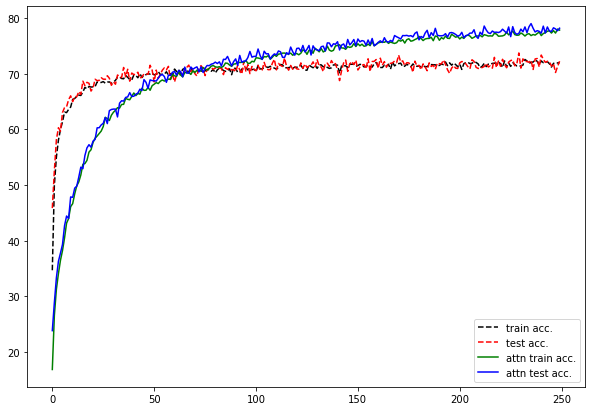

In [ ]:
fig = plt.figure(figsize=(10,7))
plt.plot(range(epoches), model_acc['train'], '--', color='k', label='train acc.')
plt.plot(range(epoches), model_acc['test'], '--', color='r', label='test acc.')
plt.plot(range(epoches), model_attn_acc['train'], color='g', label='attn train acc.')
plt.plot(range(epoches), model_attn_acc['test'], color='b', label='attn test acc.')
         
plt.legend()
plt.show()

최고 정확도는 다음과 같습니다. 어텐션 모델이 학습은 느리지만 지속적으로 성능이 향상되어 70 에폭쯤에서 추월하는 모습을 볼 수 있습니다.

In [ ]:
print(np.max(model_acc['test']))
print(np.max(model_attn_acc['test']))

73.75737762451172
79.03790283203125


## 모델 테스트

이제 학습된 두 신경망을 간단히 테스트하고 어텐션 가중치가 어떻게 생성되는지 확인해보도록 합시다.

In [ ]:
model.eval()
model_attn.eval()

MnistAttn(
  (blocked_linears): ModuleList(
    (0): Linear(in_features=49, out_features=16, bias=True)
    (1): Linear(in_features=49, out_features=16, bias=True)
    (2): Linear(in_features=49, out_features=16, bias=True)
    (3): Linear(in_features=49, out_features=16, bias=True)
    (4): Linear(in_features=49, out_features=16, bias=True)
    (5): Linear(in_features=49, out_features=16, bias=True)
    (6): Linear(in_features=49, out_features=16, bias=True)
    (7): Linear(in_features=49, out_features=16, bias=True)
    (8): Linear(in_features=49, out_features=16, bias=True)
    (9): Linear(in_features=49, out_features=16, bias=True)
    (10): Linear(in_features=49, out_features=16, bias=True)
    (11): Linear(in_features=49, out_features=16, bias=True)
    (12): Linear(in_features=49, out_features=16, bias=True)
    (13): Linear(in_features=49, out_features=16, bias=True)
    (14): Linear(in_features=49, out_features=16, bias=True)
    (15): Linear(in_features=49, out_features=16, b

In [ ]:
# 데이터 로더로 부터 미니배치 하나 얻어오기
test_loader_iter = iter(test_loader)
batch = test_loader_iter.next()

# 미니배치를 7x7 패치로 자르기
blocked_batch = torch.tensor(blockshaped(batch['image'].numpy(), 7, 7))

# 포워드 시키기
blocked_batch = blocked_batch.cuda()

out_model = model(blocked_batch)
out_model = torch.exp(out_model).argmax(axis=1)

out_model_attn = model_attn(blocked_batch)
out_model_attn = torch.exp(out_model_attn).argmax(axis=1)

print('target          : ', batch['target'])
print('model pred.     : ', out_model)
print('model attn pred.: ', out_model_attn)


target          :  tensor([0, 1, 6, 2, 0, 2, 9, 5, 5, 8])
model pred.     :  tensor([0, 1, 6, 2, 0, 2, 9, 5, 5, 8], device='cuda:0')
model attn pred.:  tensor([0, 1, 0, 2, 0, 2, 8, 5, 5, 8], device='cuda:0')


우습게도 하필 이번에 뽑은 미니배치에 대해서는 기본모델인 `Mnist`가 더 좋은 결과를 만들내내요. 어차피 두모델이 정확도 73%, 79% 밖에 되지 않으니 충분히 있을 수 있는 결과입니다. 

이제 `MnistAttn`이 어떻게 어텐션을 했는지 확인해보겠습니다.

5


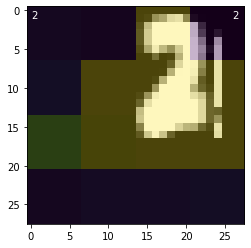

In [ ]:
sample_idx = np.random.randint(batch_size)
print(sample_idx)

plt.imshow(batch['image'][sample_idx], cmap='gray')
plt.text(0, 1, batch['target'][sample_idx].item(), color='w')
plt.text(26, 1, out_model_attn[sample_idx].item(), color='w')

alpha = model_attn.alpha[sample_idx].reshape(4,4).detach().cpu()
alpha = torch.repeat_interleave(
    torch.repeat_interleave(alpha, torch.tensor([7, 7, 7, 7]), dim=0),
    torch.tensor([7, 7, 7, 7]), dim=1
    )

plt.imshow(alpha, alpha=0.3)

그림에서 노란색으로 표시될 수록 강하게 어텐션하는 블록을 입니다. 그리고 상단에 작은 숫자는 왼쪽이 정답, 오른쪽이 예측 결과입니다. 숫자 2가 있는 위치를 강하게 어텐션하고 있네요. 내친김에 선택된 이미지 열개에 대해서 어텐션 가중치를 모두 확인해봅시다.

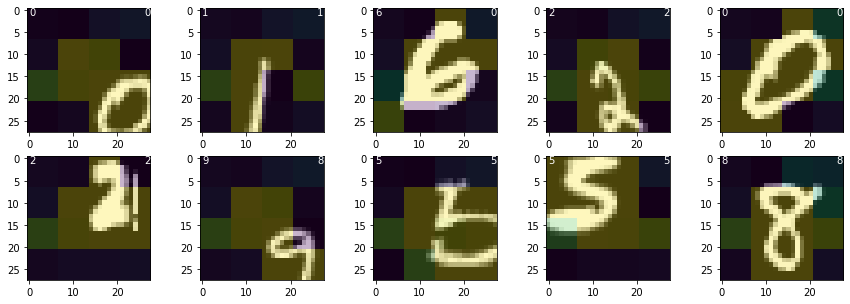

In [ ]:
fig, ax = plt.subplots(figsize=(15,5), nrows=2, ncols=5)

for sample_idx in range(batch_size):
    ax[sample_idx//5, sample_idx%5].imshow(batch['image'][sample_idx], cmap='gray')
    ax[sample_idx//5, sample_idx%5].text(0, 1, batch['target'][sample_idx].item(), color='w')
    ax[sample_idx//5, sample_idx%5].text(26, 1, out_model_attn[sample_idx].item(), color='w')

    alpha = model_attn.alpha[sample_idx].reshape(4,4).detach().cpu()
    alpha = torch.repeat_interleave(
    torch.repeat_interleave(alpha, torch.tensor([7, 7, 7, 7]), dim=0),
    torch.tensor([7, 7, 7, 7]), dim=1
    )
    ax[sample_idx//5, sample_idx%5].imshow(alpha, alpha=0.3)    
    


 열개 이미지에 대해서 적절하게 어텐션이 되고 있음을 확인할 수 있습니다. 특히 이미지 증강 기법으로 숫자가 구석으로 이동된 경우도 어텐션이 숫자를 따라 가는 것이 인상적입니다. 하지만 1번 샘플과 7번 샘플을 보면 가운데 네개 패치는 숫자 위치와 상관없이 항상 강하게 어텐션하는 것 처럼 보이기도 합니다. 

## 마무리

이렇게 mnist 데이터 세트를 이용해서 간단하게 어텐션에 대해서 알아봤습니다. 물론 어텐션을 제대로 적용하기 위해서는 Key, Query, Value라는 개념이 등장해야 합니다. 이 개념을 제대로 적용하려면 인코더-디코더 모델에 적용하는 크로스 어텐션을 이야기해야하는데 너무 복잡하고 또 그렇게 설명하는 대부분의 문서와 다르게 설명하기 위해 이글을 시작했었죠? Key, Query, Value에 대해 이야기하지 않았지만 그리 어려운 개념은 아니며 이 글에서 어텐션의 기본 개념을 잘 이해했다면 쉽게 이해도 가능합니다. 실제 seq2seq나 트랜스포머같은 인코더-디코더 모델에 적용된 어텐션을 공부할 때 그 내용을 이해하기 훨씬 쉬워졌을 것이라 확신합니다.

이상으로 글을 마무리 하며 아직 어텐션을 공부하지 않은 분들께 도움이 되었으면 좋겠습니다. 


In [ ]:
# 혹시 이글을 로컬 런타임에 연결해서 실행하고 있다면 
# 아래 문작을 실행해서 모델 파라미터를 저장할 수 있다.
torch.save(model.state_dict(), "mnist-btch_10-lr_0.3-shft_0.3-scl_-0.4-rot_0-epc_250.pth")
torch.save(model.state_dict(), "mnistattn-btch_10-lr_0.3-shft_0.3-scl_-0.4-rot_0-epc_250.pth")